# things to to in the code

1. the network needs to run without external stimulus:

  a. set the initial stimulus,

  b. configure sinaptic connections

  c. record spikes for 1 second and see if the network stops or tends to stop

2. Configure the external stimulus

  a. Configure the extracelular stimulus

  b. see if it works with the raster plot

3. Configure LFP recording with the NetPyNE method

4. collect the data

In [1]:
!pip install neuron
!pip install netpyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.1 MB/s eta 0:00:00


In [13]:
import matplotlib.pyplot as plt
import os
import numpy as np
from netpyne import specs, sim
import neuron

netParams = specs.NetParams()

# To create a network with a cylindrical shape

# netParams.scale = 1.0 # Scale factor for number of cells
# netParams.sizeX = 250.0 # x-dimension (horizontal length) size in um
# netParams.sizeY = 250.0 # y-dimension (vertical height or cortical depth) size in um
# netParams.sizeZ = 250.0 # z-dimension (horizontal depth) size in um
# netParams.shape = 'cylinder' # cylindrical (column-like) volume
# netParams.defaultDelay = 0.1 # default conn delay (ms)
# netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)


**Creating the Network**

In [3]:
## Cell parameters/rules

# soma geometry
PYRcell = {'secs': {}}
PYRcell['secs']['soma'] = {'geom': {}, 'mechs': {}}
PYRcell['secs']['soma']['geom'] = {
    'diam': 18.8, # diameter
    'L': 18.8, # length
    'Ra': 123.0 # axial resistance
}
# soma hh mechanism
PYRcell['secs']['soma']['mechs']['hh'] = {
    'gnabar': 0.12, # maximum Na conductance
    'gkbar': 0.036, # maximum K conductance
    'gl': 0.003, # leak conductance
    'el': -70 #
}
PYRcell['secs']['soma']['mechs']['extracellular'] = {} # Adding the extracellular mechanism
# dendrite configuration
PYRcell['secs']['dend'] = {'geom': {}, 'topol': {}, 'mechs': {}}
PYRcell['secs']['dend']['geom'] = {'diam': 5.0, 'L': 150.0, 'Ra': 150.0, 'cm': 1}
PYRcell['secs']['dend']['topol'] = {'parentSec': 'soma', 'parentX': 1.0, 'childX': 0}
PYRcell['secs']['dend']['mechs']['pas'] = {'g': 0.0000357, 'e': -70}

netParams.cellParams['PYR'] = PYRcell # Adding all the configuration to the pyramidal cell of netParams.cellParams

In [4]:
## Population parameters

# Excitatory cells (close to the electrode)
netParams.popParams['E'] = {
    'cellType': 'PYR',
    'numCells': 40,
    'xRange': [0, 250],
    'yRange': [0, 250],
    'zRange': [0, 250]
}
# Inhibitory cells (close to the electrode)
netParams.popParams['I'] = {
    'cellType': 'PYR',
    'numCells': 10,
    'xRange': [0, 250],
    'yRange': [0, 250],
    'zRange': [0, 250]
}


## Synaptic mechanism parameters

# excitatory synaptic mechanism
netParams.synMechParams['exc'] = {
    'mod': 'Exp2Syn', # model
    'tau1': 0.2, # rise time
    'tau2': 1.8, # decay time
    'e': 0 # equilibrium potential
}
# inhibitory synaptic mechanism
netParams.synMechParams['inh'] = {
    'mod': 'Exp2Syn',
    'tau1': 0.1,
    'tau2': 9.0,
    'e': -80
}

In [5]:
## Cell connectivity rules

# Close excitatory cells to all cells
netParams.connParams['E->all'] = { #S -> I label
    'preConds': {'pop': 'E'}, # conditions of presyn cells
    'postConds': {'pop': ['E', 'I']}, # conditions of postsyn cells
    'probability': 0.1, # probability of connection
    'weight': '0.005', # synaptic weight
    'delay': 'defaultDelay+dist_3D/propVelocity', # transmission delay (ms), spatially dependent
    'synMech': 'exc' # synaptic mechanism
}
# Close inhibitory cells to all cells
netParams.connParams['I->all'] = {
    'preConds': {'pop': 'I'},
    'postConds': {'pop': ['E', 'I']},
    'probability': 0.1,
    'weight': '0.005',
    'delay': 'defaultDelay+dist_3D/propVelocity',
    'synMech': 'inh'
}

**Inserting Background Activity (Optional)**

In [6]:
#Background activity parameters
netParams.stimSourceParams['bkg'] = {
   'type': 'NetStim',
   'rate': 1, #Hz
   'noise': 0.5
}
netParams.stimTargetParams['bkg'] = {
   'source': 'bkg',
   'conds': {'pop': ['E', 'I']},
   'weight': 0.015,
   'delay': 5,
   'synMech': 'exc'
}

**Configuring the Simulation**

In [7]:
## Simulation options
simConfig = specs.SimConfig() # object of class SimConfig to store simulation configuration

simConfig.seeds = {'conn': 1, 'stim': 1, 'loc': 1}
simConfig.hParams = {'v_init': -65}

simConfig.duration = 5000 # Duration of the simulation, in ms
simConfig.dt = 0.01 # Internal integration timestep to use
simConfig.verbose = False # Show detailed messages
simConfig.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}} # Dict with traces to record
simConfig.recordStep = 0.01 # Step size in ms to save data (e.g. V traces, LFP, etc)
simConfig.filename = 'netpynenetwork' # Set file output name
simConfig.savePickle = False # Save params, network and sim output to Pickle file
simConfig.saveJson = False # Save params, network and sim output to Json file

simConfig.analysis['plotRaster'] = {'timeRange': [0, 5000]}
simConfig.analysis['plotTraces'] = {'include': [gid for gid in range(50)], 'timeRange': [0, 5000], 'ylim': [-80, 50]}  # Plot recorded traces for this list of cells

#sim.createSimulateAnalyze(netParams, simConfig) # Create the network
#sim.net.defineCellShapes() # Add 3D points to sections with simplified geometry

**Configuring the Electrode**

In [8]:
# The parameters of the extracellular point current source
acs_params = {
    'position': [125, 25, 125], # um
    'amp': 75000, # uA
    'duration': 0.1, # ms
    'stimstart': 0, # ms
    'stimend': 10000, # ms
    'sigma': 0.3 # decay constant
}
simConfig = specs.SimConfig() # object of class SimConfig to store simulation configuration
simConfig.dt = 0.01 # Internal integration timestep to use

**Creating the Wave Patterns**

In [9]:
%matplotlib inline

In [10]:
# NPS
dur = int((acs_params['stimend']-acs_params['stimstart'])/1000)  # Stimulus duration
time_pulses = np.zeros(0)
for s in range(0, dur):
  t0 = 0 # Inferior time limit of the first pulse
  tf = 940 # Superior time limit of the first pulse

  for ms in range(0, 4): # 4 pulses per second
    random = np.random# Makes .uniform(0, 1) # Generates a random number
    NPS_pulse = random*(tf - t0) + t0 # Calculates the time stamp with the limit restriction

    if (NPS_pulse - t0 < 20): # Guarantees that the minimum IPI is 20 ms
      NPS_pulse = t0 + 20

    time_pulses = np.append(time_pulses, int(NPS_pulse) + s*1000 + acs_params['stimstart']) # Saves the time stamps

    t0 = int(NPS_pulse) # Resets the inferior time limit for the next pulse
    tf = tf + 20 # Resets the superior time limit for the next pulse

# Plotting the Interpulse Interval (IPI)
NPS_IPI = np.diff(time_pulses) # Getting the IPI for the NPS
figSize = (9,5)
fontsiz = 22
fig = plt.figure(figsize=figSize)  # Open a new figure
plt.hist(NPS_IPI, 100) # Plotting histogram
plt.xlabel('Inter-pulse interval (ms)', fontsize=fontsiz)
plt.ylabel('Count of occurrences', fontsize=fontsiz)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('IPI histogram', fontsize=fontsiz)
plt.savefig('IPI_NPS.png', facecolor = 'white' , dpi=300)
plt.show()

# Inserting the pulse duration
time_pulses2 = []
for cont in time_pulses:
  time_pulses2 += [(cont + simConfig.dt*tp) for tp in range(int(acs_params['duration']/simConfig.dt)+1)]
time_pulses = time_pulses2
# time_pulses

TypeError: unsupported operand type(s) for *: 'module' and 'int'

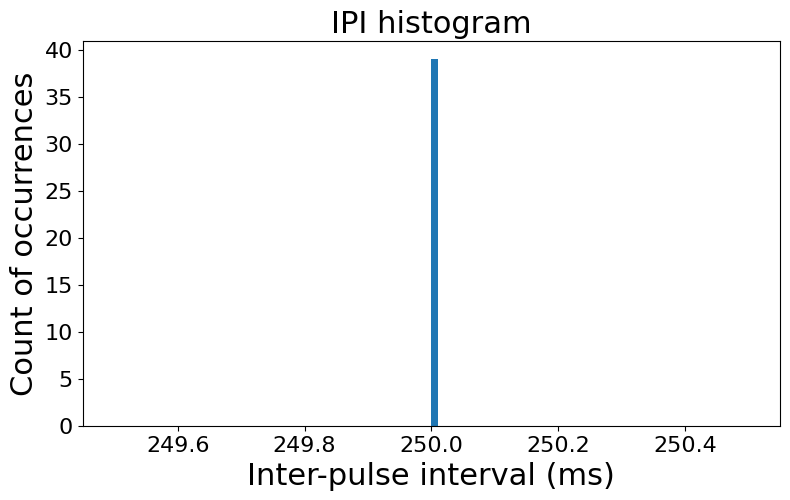

In [15]:
# Periodic
periodic = np.zeros(int((acs_params['stimend'] - acs_params['stimstart'])/simConfig.dt + 1))
interval = int(250/simConfig.dt) #ms
periodic_pulses = []
for cont in range(0, len(periodic)-1, interval): # Makes periodic pulses with 250 ms IPI and with pulse duration
  periodic_pulses.append(cont*simConfig.dt) # Saving the time stamps
  for cont2 in range(int(acs_params['duration']/simConfig.dt)): # Inserting the pulse duration
    periodic[cont+cont2] = 1
# periodic

# Plotting the Interpulse Interval (IPI)
periodic_IPI = np.diff(periodic_pulses) # Getting the IPI for the Periodic
figSize = (9,5)
fontsiz = 22
fig = plt.figure(figsize=figSize)  # Open a new figure
plt.hist(periodic_IPI, 100) # Plotting histogram
plt.xlabel('Inter-pulse interval (ms)', fontsize=fontsiz)
plt.ylabel('Count of occurrences', fontsize=fontsiz)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('IPI histogram', fontsize=fontsiz)
#plt.savefig('IPI_Periodic.png', facecolor = 'white' , dpi=300)
plt.show()

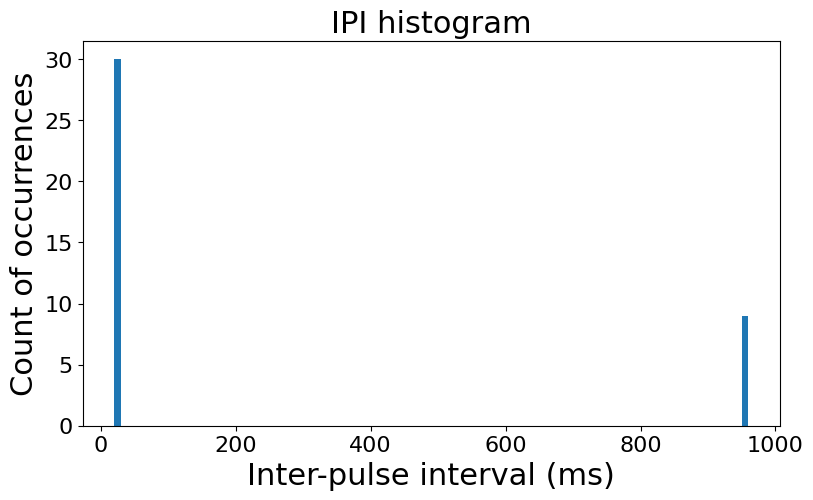

In [16]:
# Burst
burst = np.zeros(int((acs_params['stimend'] - acs_params['stimstart'])/simConfig.dt + 1))
cont = 0
burst_pulses = []
while (cont <= len(burst)): # Makes 4 pulses per second with 20 ms IPI and with pulse duration
  cont = int(cont + 20/simConfig.dt) # Time of the first of the 4 pulses
  burst_pulses.append(cont*simConfig.dt) # Saving the time stamps
  for cont2 in range(cont, cont + int(acs_params['duration']/simConfig.dt)): # Inserting the pulse duration
    burst[cont2] = 1
  cont = int(cont + 20/simConfig.dt)
  burst_pulses.append(cont*simConfig.dt)
  for cont2 in range(cont, cont + int(acs_params['duration']/simConfig.dt)):
    burst[cont] = 1
  cont = int(cont + 20/simConfig.dt)
  burst_pulses.append(cont*simConfig.dt)
  for cont2 in range(cont, cont + int(acs_params['duration']/simConfig.dt)):
    burst[cont] = 1
  cont = int(cont + 20/simConfig.dt)
  burst_pulses.append(cont*simConfig.dt)
  for cont2 in range(cont, cont + int(acs_params['duration']/simConfig.dt)):
    burst[cont] = 1
  cont = int(cont + 940/simConfig.dt)
# burst

# Plotting the Interpulse Interval (IPI)
burst_IPI = np.diff(burst_pulses) # Getting the IPI for the Burst
figSize = (9,5)
fontsiz = 22
fig = plt.figure(figsize=figSize)  # Open a new figure
plt.hist(burst_IPI, 100) # Plotting histogram
plt.xlabel('Inter-pulse interval (ms)', fontsize=fontsiz)
plt.ylabel('Count of occurrences', fontsize=fontsiz)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('IPI histogram', fontsize=fontsiz)
#plt.savefig('IPI_Burst.png', facecolor = 'white' , dpi=300)
plt.show()

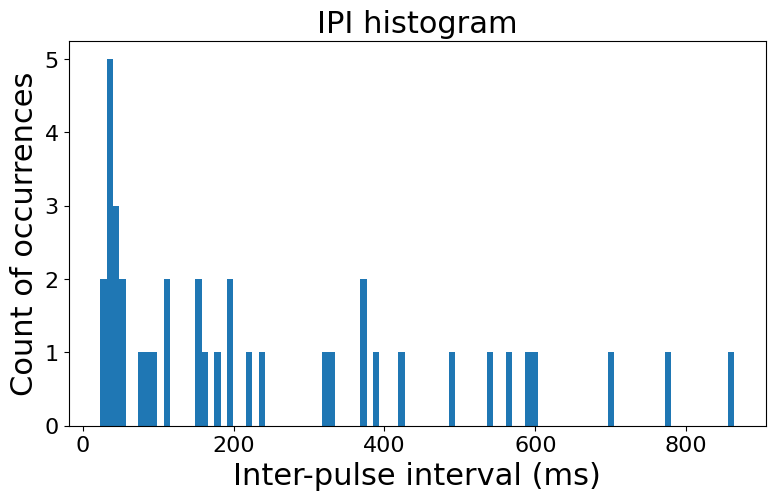

In [17]:
# NPSLH
dur = int((acs_params['stimend']-acs_params['stimstart'])/1000) # Stimulus duration
npslh = np.zeros(0)
for x in range(0, dur):
	for y in range(0, 4): # Makes 4 pulses per second
		npslh = np.append(npslh, np.random.uniform(0, 1)*1000 + 1000*x + acs_params['stimstart']) # Gets a random time stamp and add it to the npslh vector

npslh.sort() # Rearranging the vector in ascending order

for x in range(0, dur*4): # Guarantees that the minimum IPI is 20 ms
	if (npslh[-x] - npslh[-x-1] < 20):
		npslh[-x-1] = npslh[-x-1] - 20

# Plotting the Interpulse Interval (IPI)
NPSLH_IPI = np.diff(npslh) # Getting the IPI for the NPSLH
figSize = (9,5)
fontsiz = 22
fig = plt.figure(figsize=figSize)  # Open a new figure
plt.hist(NPSLH_IPI, 100) # Plotting histogram
plt.xlabel('Inter-pulse interval (ms)', fontsize=fontsiz)
plt.ylabel('Count of occurrences', fontsize=fontsiz)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('IPI histogram', fontsize=fontsiz)
plt.savefig('IPI_NPSLH.png', facecolor = 'white' , dpi=300)
plt.show()

# Inserting the pulse duration
npslh2 = []
for cont in npslh:
  npslh2 += [(cont + simConfig.dt*tp) for tp in range(int(acs_params['duration']/simConfig.dt)+1)]
npslh = npslh2
# npslh

**Creating the Extracellular Field and Stimulation**

In [18]:
def insert_v_ext(cell, v_ext, t_ext):
  cell.t_ext = neuron.h.Vector(t_ext) # Time vector
  cell.v_ext = [] # Extracellular potential vector
  for v in v_ext:
    cell.v_ext.append(neuron.h.Vector(v)) # Inserting the calculated extracellular potentials of each time step in the v_ext

  # play v_ext into e_extracellular reference
  i = 0
  cell.v_ext[i].play(cell.secs['soma']['hObj'](0.5)._ref_e_extracellular, cell.t_ext)

In [19]:
def make_extracellular_stimuli(acs_params, cell):
  """ Function to calculate and apply external potential """
  x0, y0, z0 = acs_params['position'] # Position of the electrode
  ext_field = np.vectorize(lambda x, y, z: 1/(4*np.pi*acs_params['sigma']*np.sqrt((x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2))) # Calculating the propagation of the potential
  stimstart = acs_params['stimstart'] # Initial time of the stimulation
  stimend = acs_params['stimend'] # Final time of the stimulation
  stimdif = stimend-stimstart # Total time of the stimulation

  # Making the external field
  n_tsteps = int(stimdif/simConfig.dt + 1) # Total number of the stimulation time steps
  n_start = int(stimstart/simConfig.dt) # Time step of the beginnig of the stimulation
  n_end = int(stimend/simConfig.dt + 1) # Time step of the end of the stimulation
  t = np.arange(start=n_start, stop=n_end)*simConfig.dt # Time vector
  #----------------------------------------------------------------#
  time_spikes = np.arange(start=n_start, stop=n_end)*simConfig.dt
  cont2 = 0
  for cont in range(0, len(t)): # Reshaping the time stamp vector to match with the time vector
    if (t[cont] < time_pulses[cont2]):
      time_spikes[cont] = 0
    elif (t[cont] >= time_pulses[-1]):
      time_spikes[cont] = 1
      for cont3 in range(cont+1, len(t)):
        time_spikes[cont3] = 0
      break
    else:
      time_spikes[cont] = 1
      cont2 = cont2 + 1
  pulse = acs_params['amp']*time_spikes # NPS
  #----------------------------------------------------------------#
  # time_spikes = np.arange(start=n_start, stop=n_end)*simConfig.dt
  # cont2 = 0
  # for cont in range(0, len(t)): # Reshaping the time stamp vector to match with the time vector
  #   if (t[cont] < npslh[cont2]):
  #     time_spikes[cont] = 0
  #   elif (t[cont] >= npslh[-1]):
  #     time_spikes[cont] = 1
  #     for cont3 in range(cont+1, len(t)):
  #       time_spikes[cont3] = 0
  #     break
  #   else:
  #     time_spikes[cont] = 1
  #     cont2 = cont2 + 1
  # pulse = acs_params['amp']*time_spikes # NPSLH
  #----------------------------------------------------------------#
  # pulse = acs_params['amp']*periodic # Periodic
  #----------------------------------------------------------------#
  # pulse = acs_params['amp']*burst # Burst
  #----------------------------------------------------------------#
  v_cell_ext = np.zeros((cell.secs['soma']['hObj'].nseg, n_tsteps))
  v_cell_ext[:, :] = ext_field(cell.getSomaPos()[0], cell.getSomaPos()[1], cell.getSomaPos()[2]).reshape(cell.secs['soma']['hObj'].nseg, 1)*pulse.reshape(1, n_tsteps) # Calculating the extracellular potentials for each cell, due to the stimulation
  insert_v_ext(cell, v_cell_ext, t) # Inserting the extracellular potentials in the e_extracellular reference of each cell
  return ext_field, pulse

In [20]:
# Add extracellular stim
for c in range(len(sim.net.cells)):
  ext_field, pulse = make_extracellular_stimuli(acs_params, sim.net.cells[c])

AttributeError: module 'netpyne.sim' has no attribute 'net'

**Simulation and Results**

In [21]:
sim.simulate() # Simulating

AttributeError: module 'netpyne.sim' has no attribute 'cfg'

Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... cell


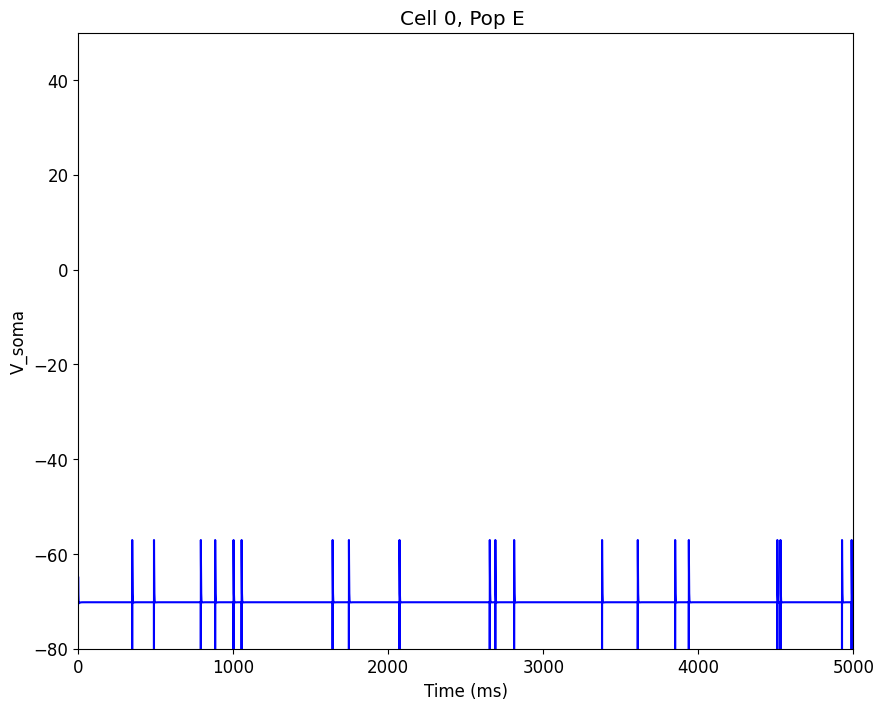

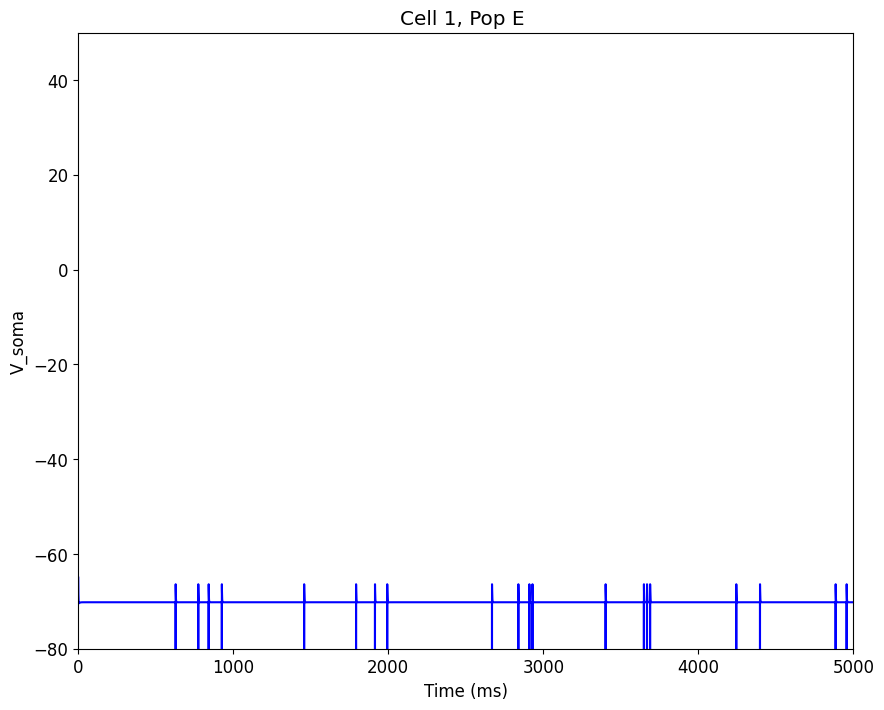

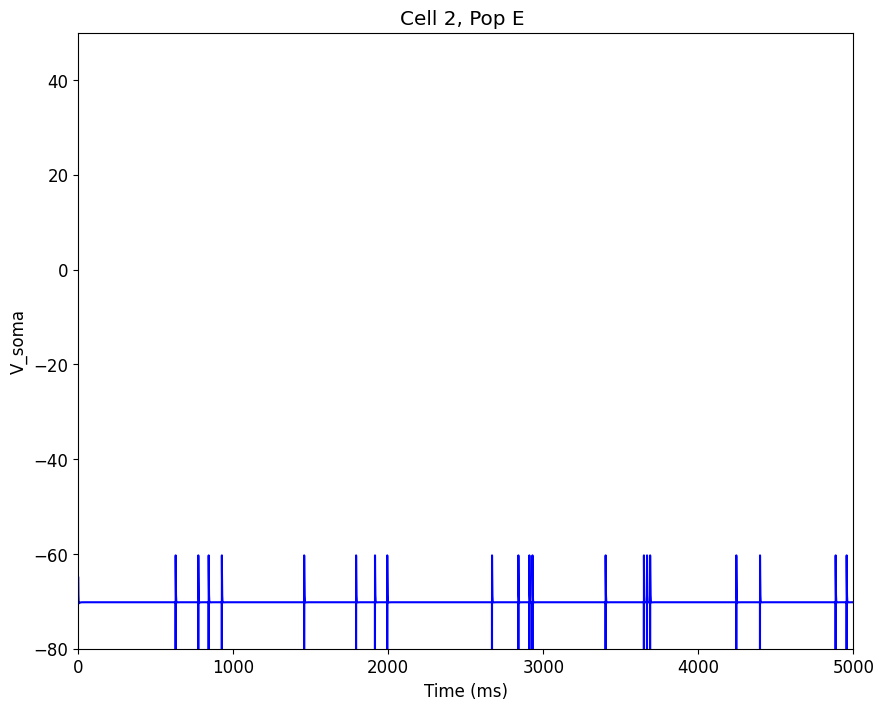

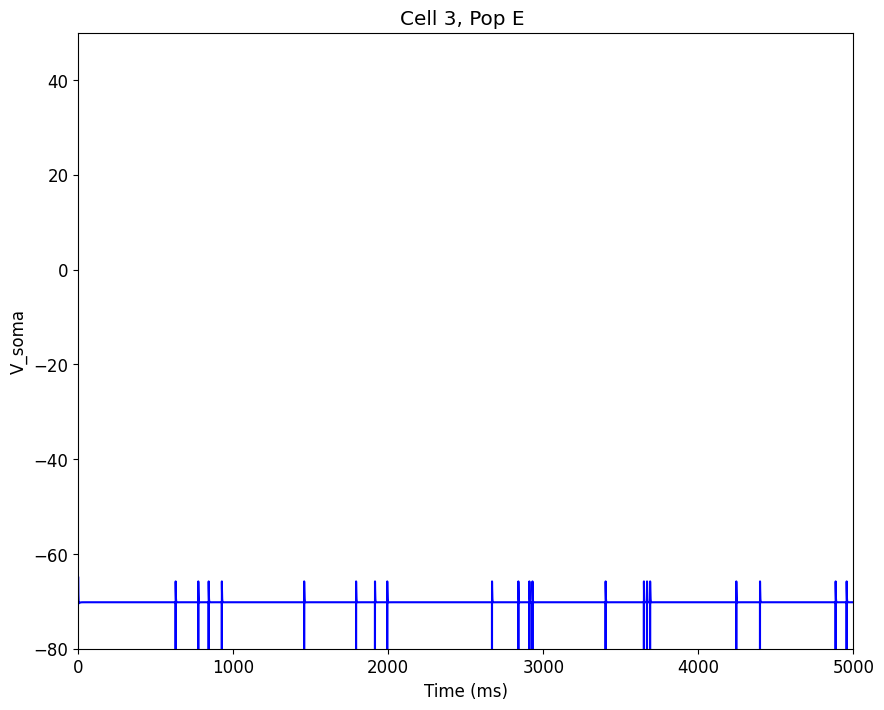

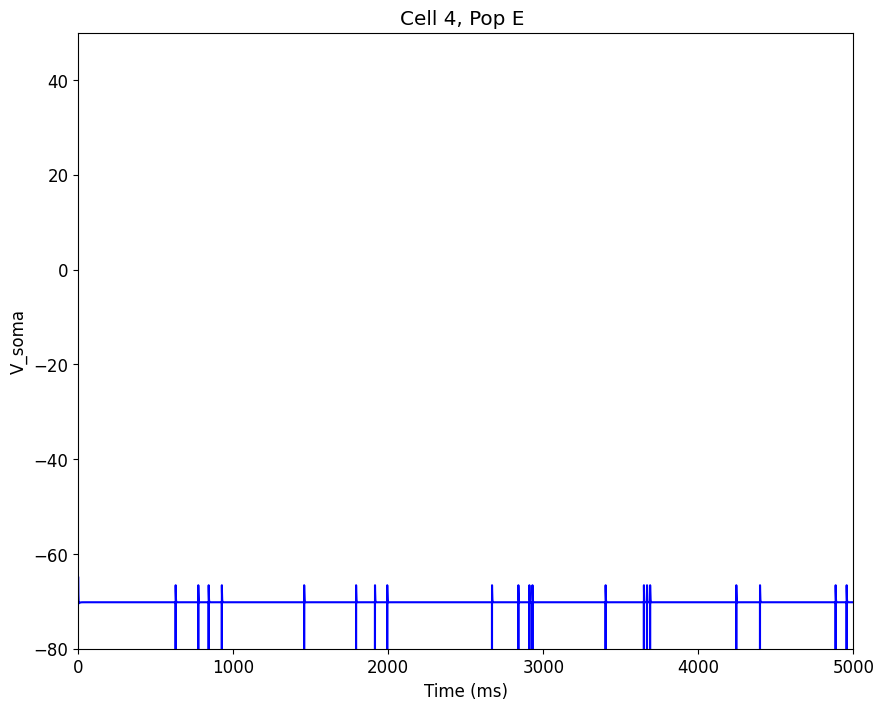

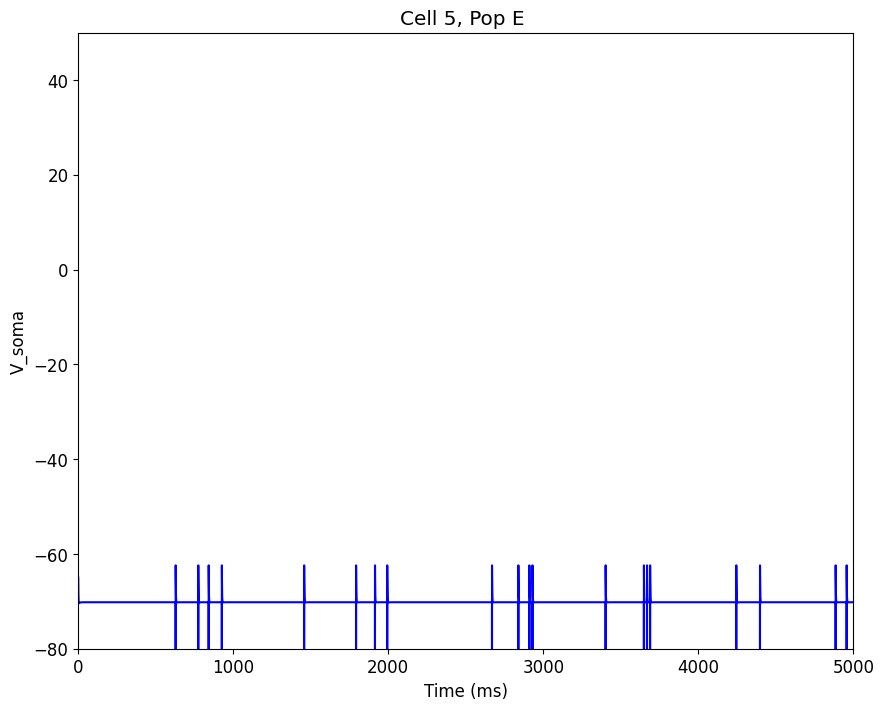

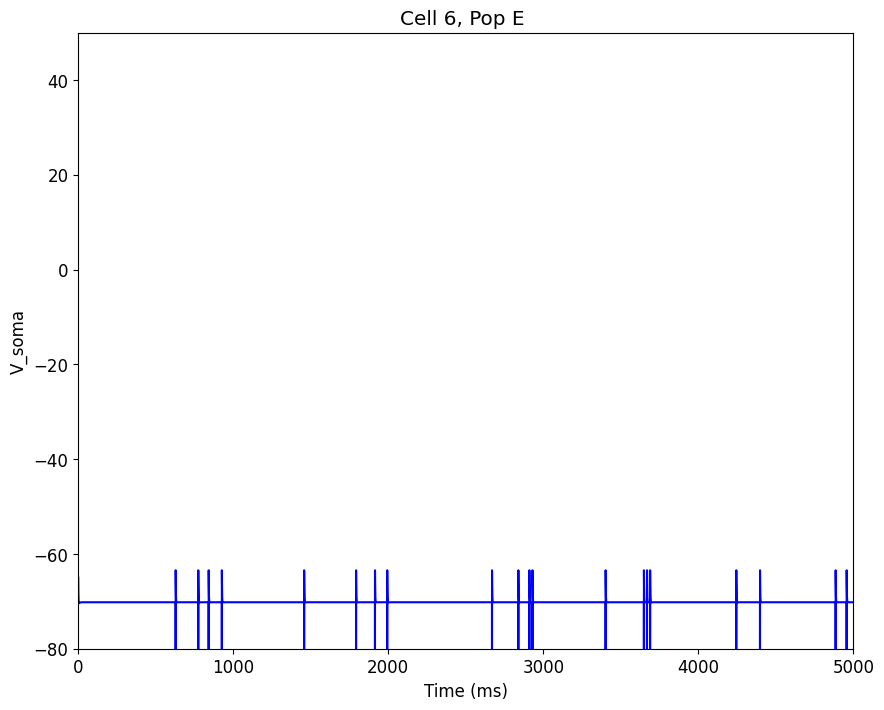

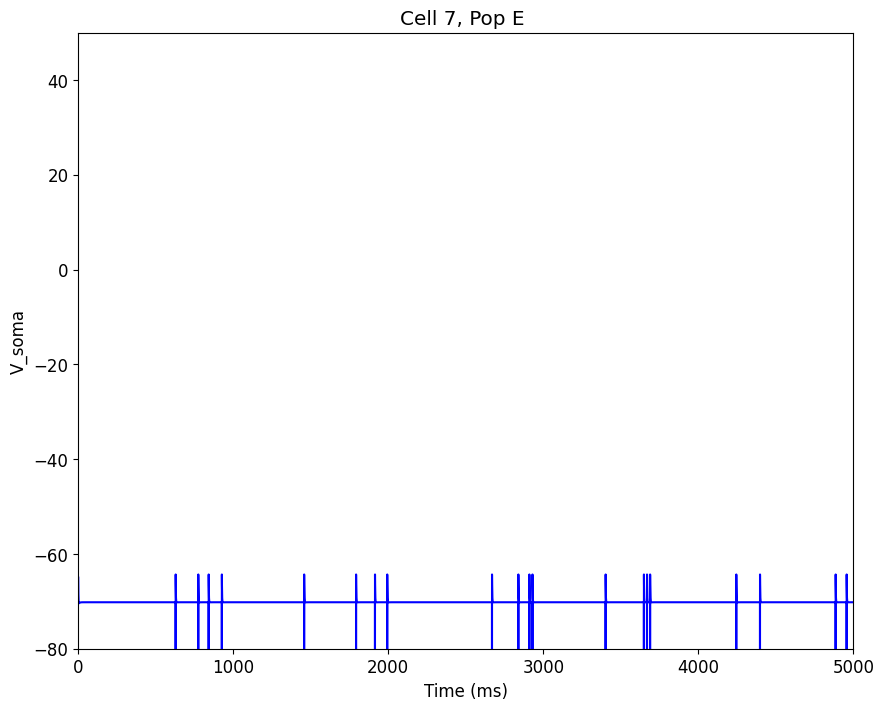

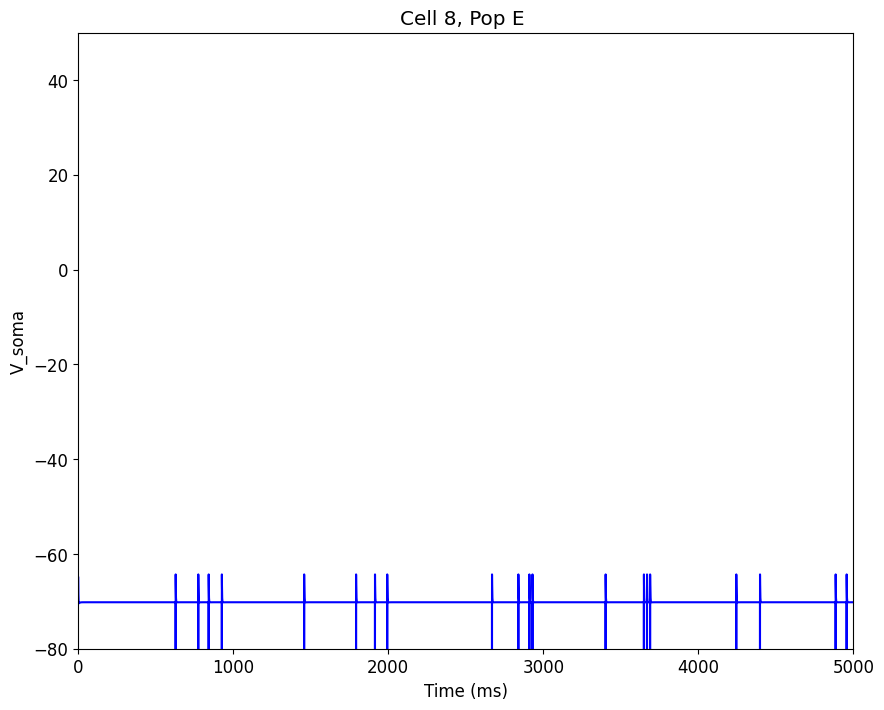

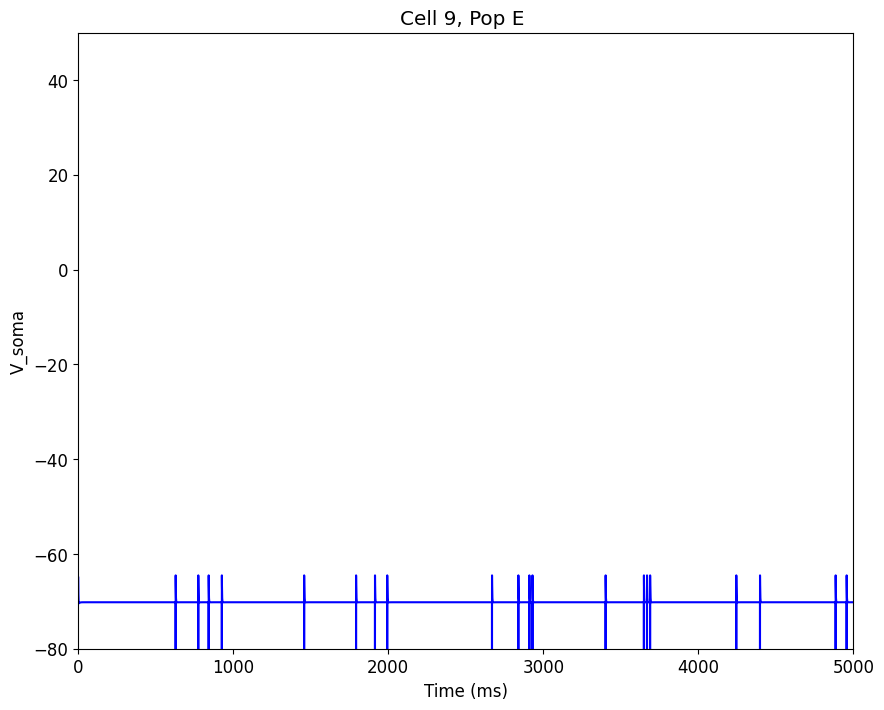

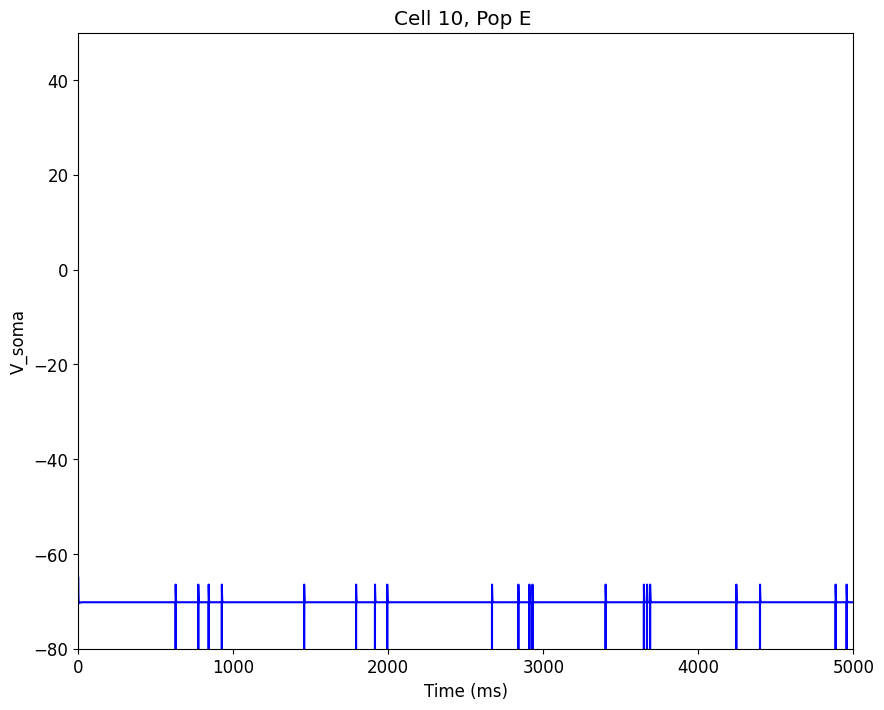

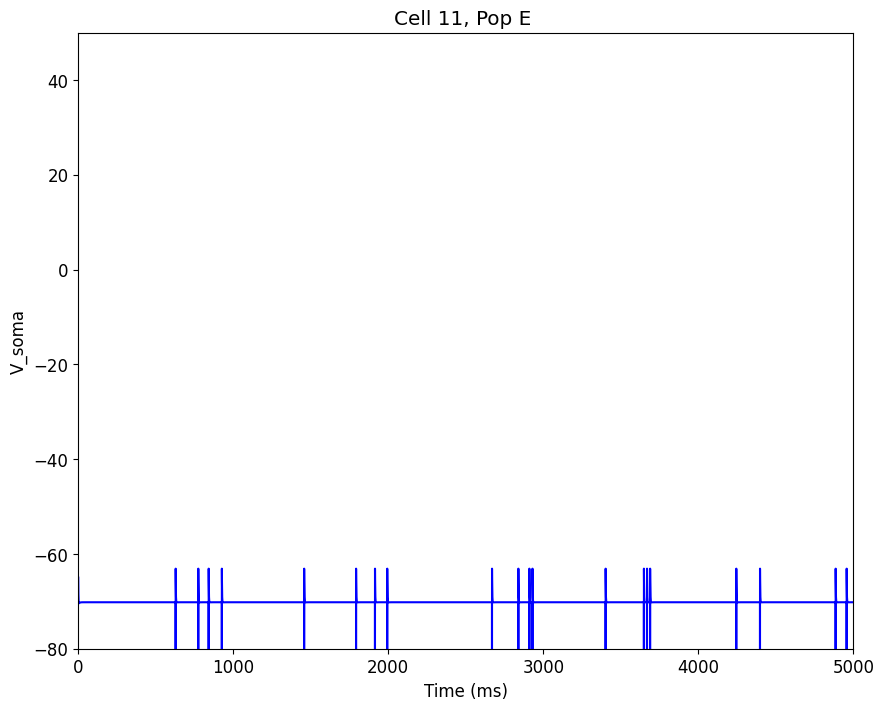

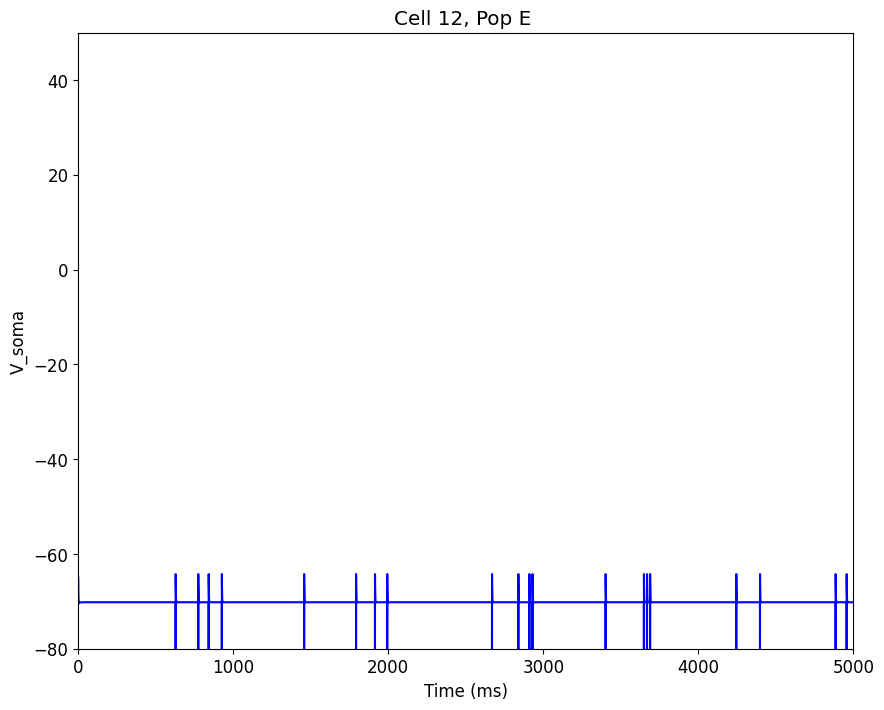

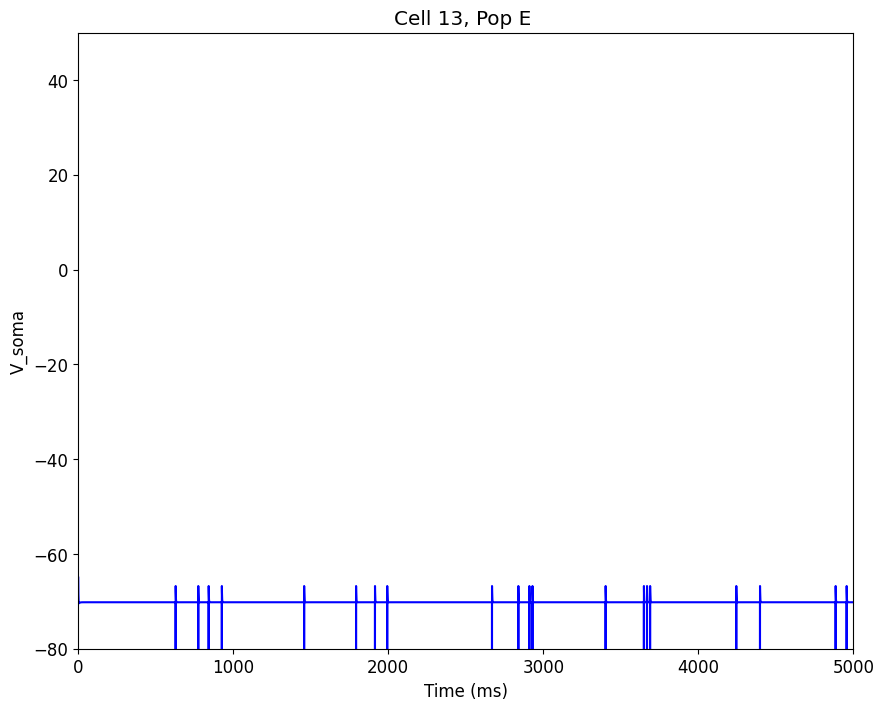

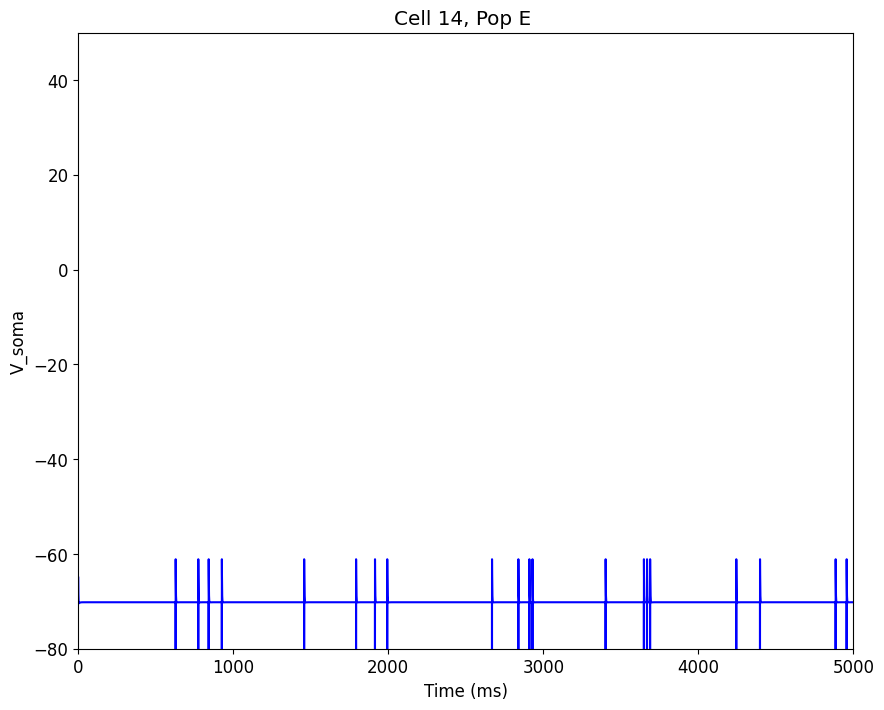

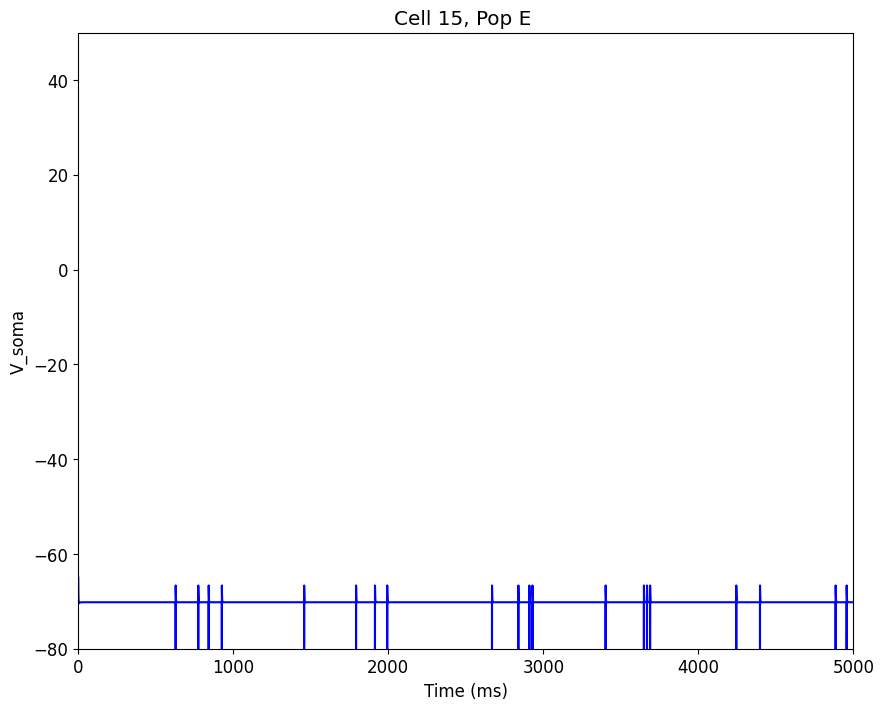

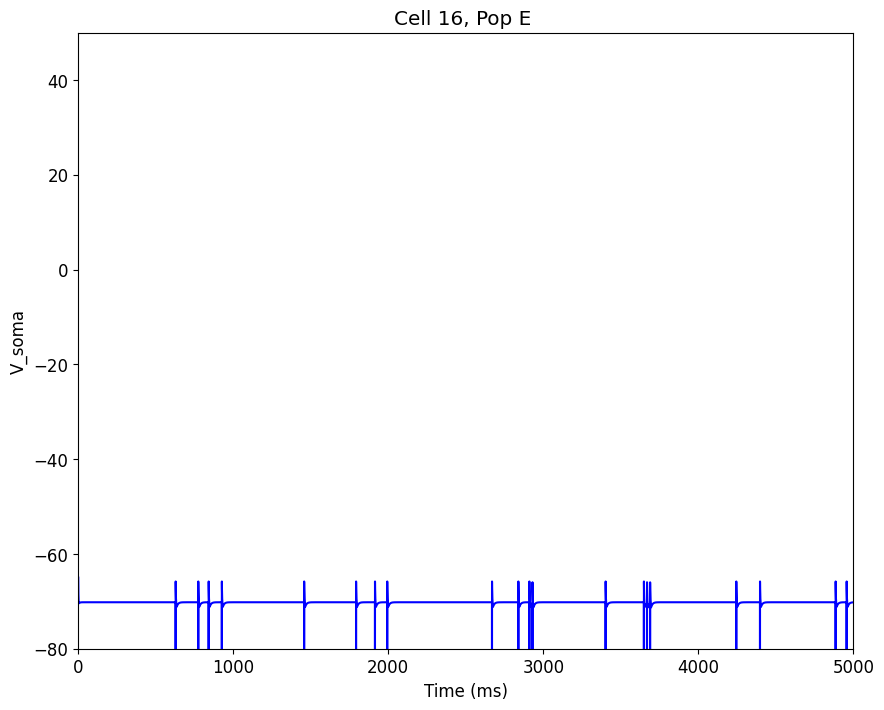

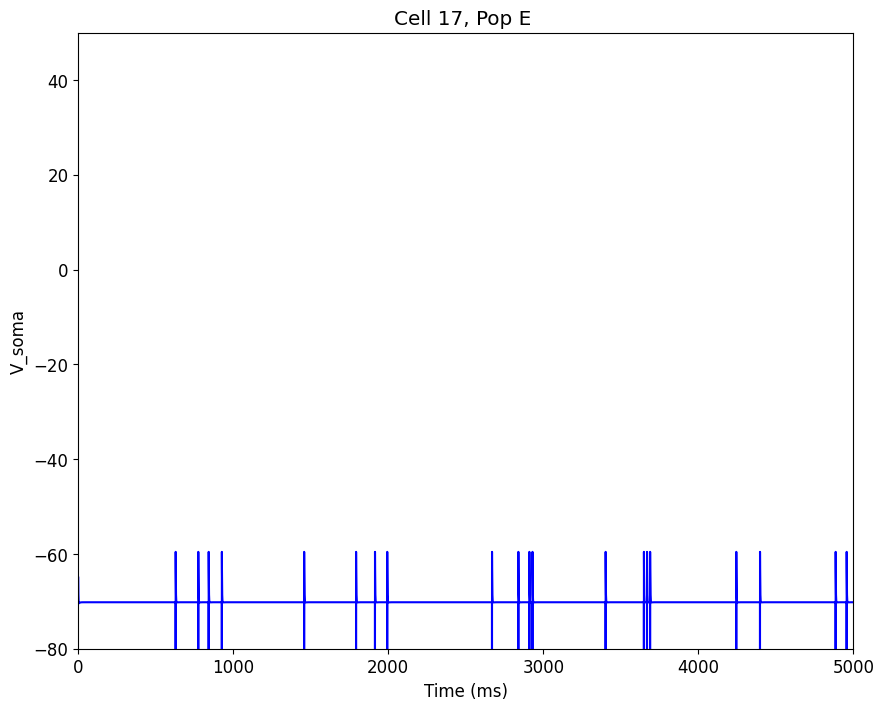

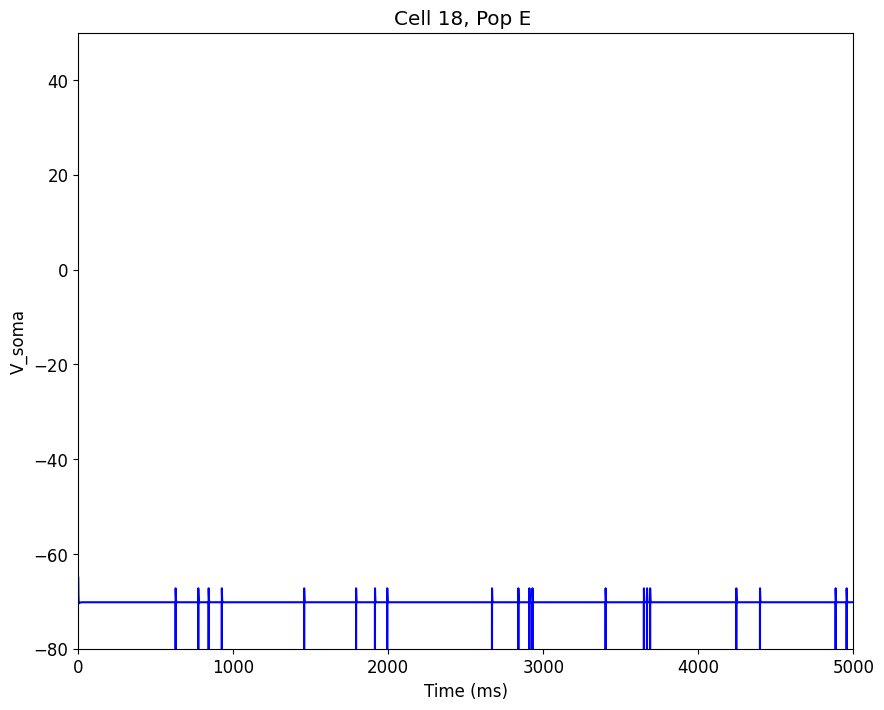

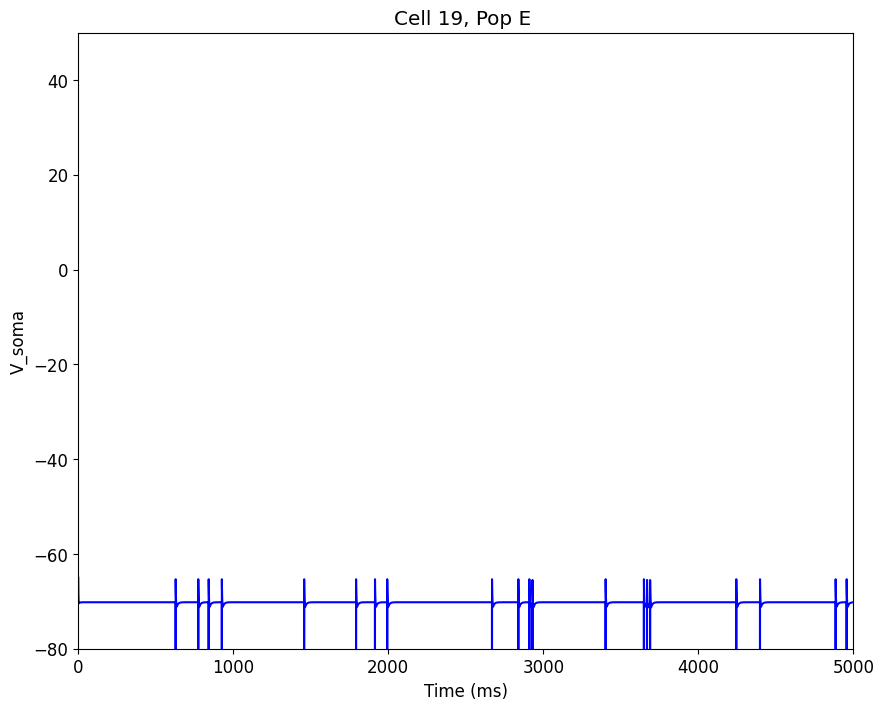

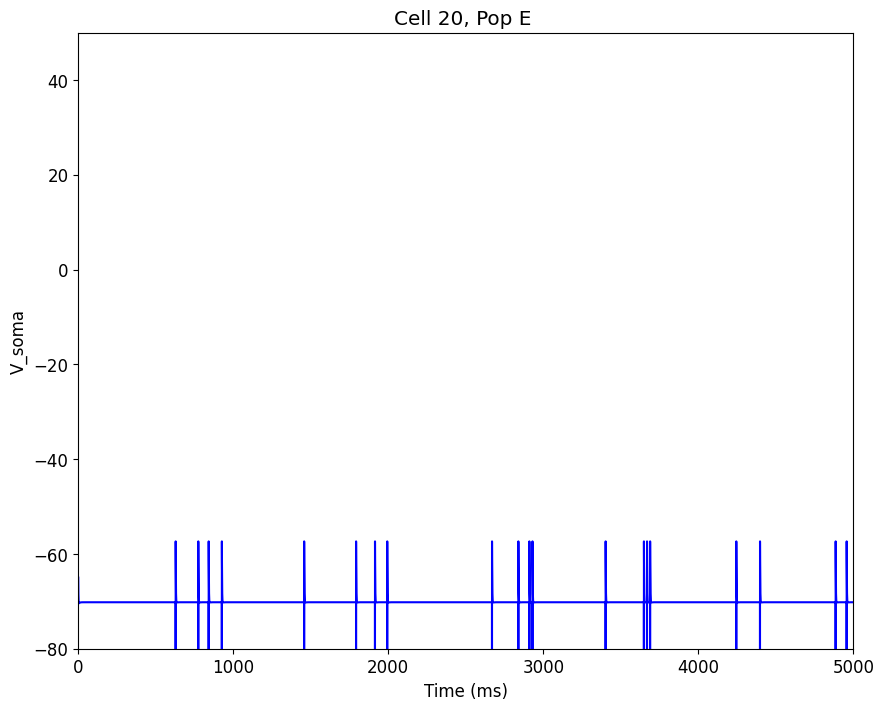

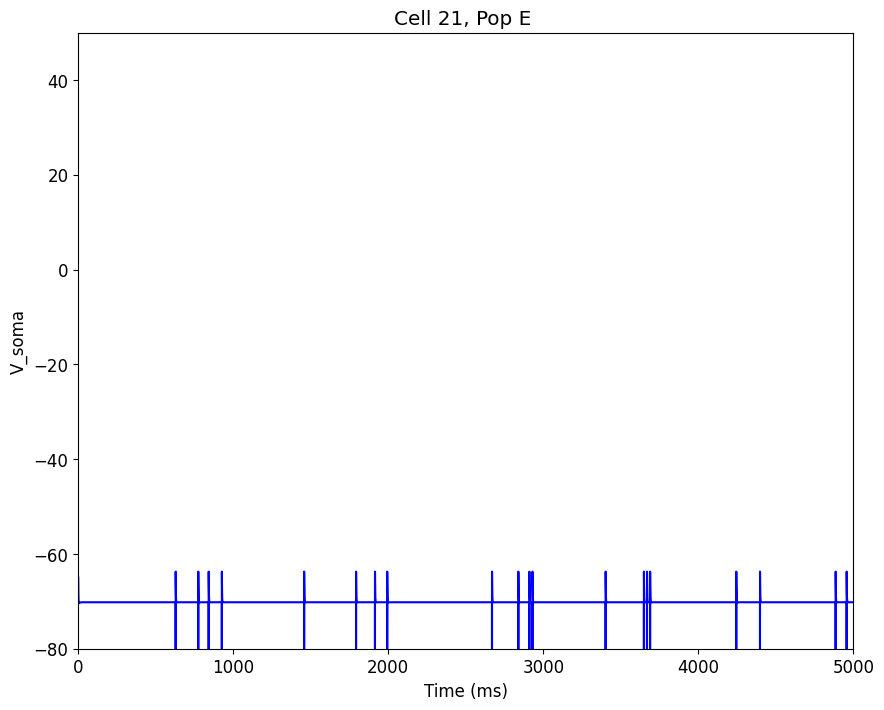

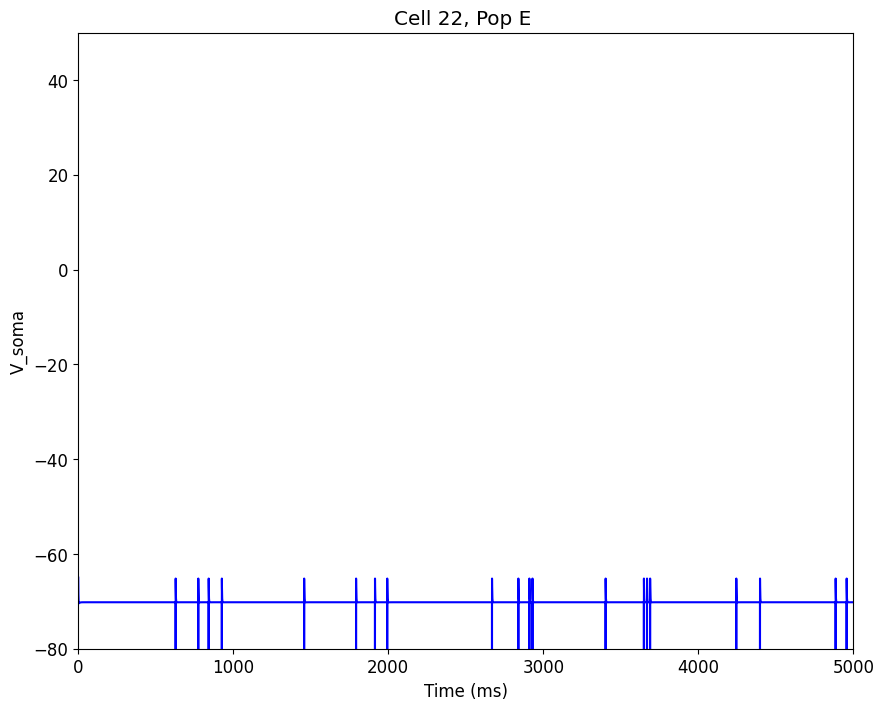

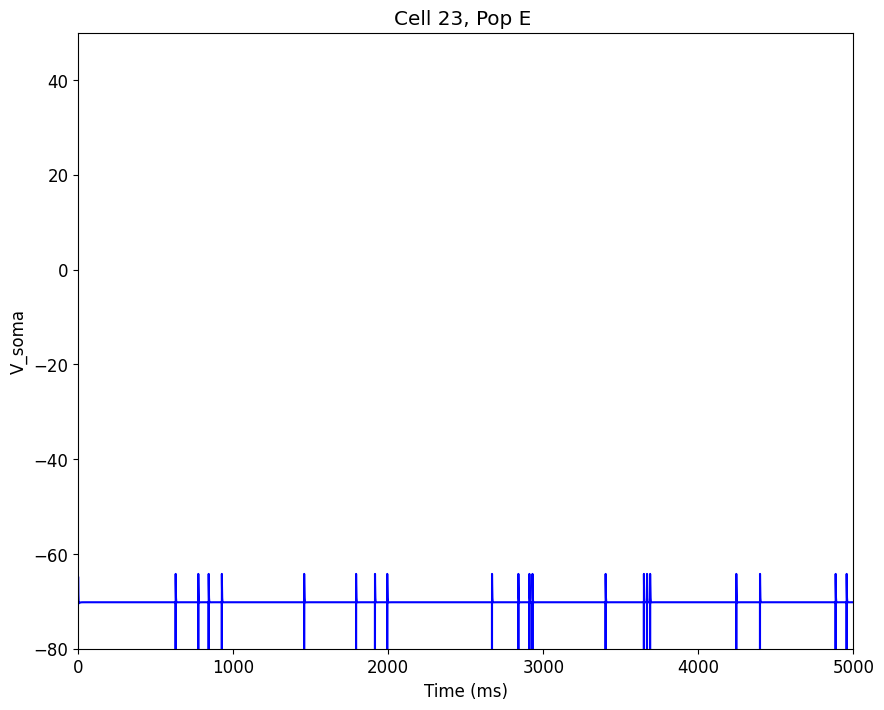

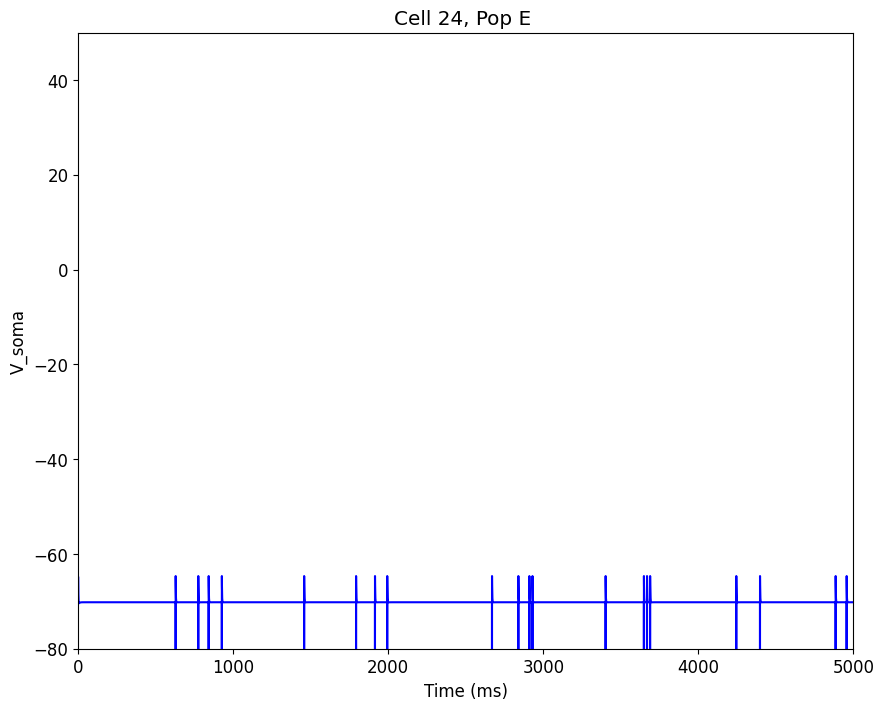

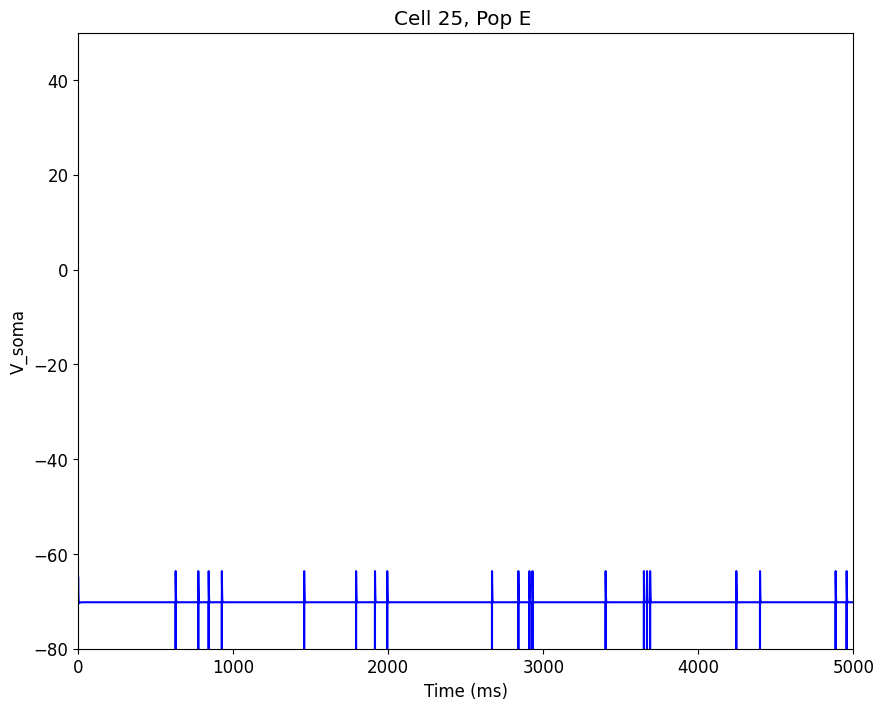

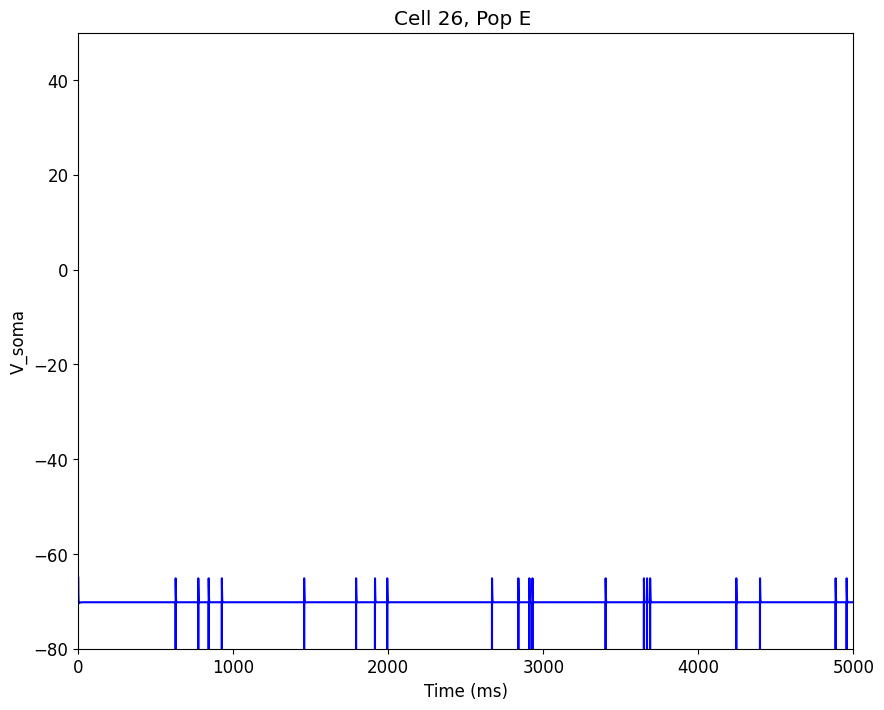

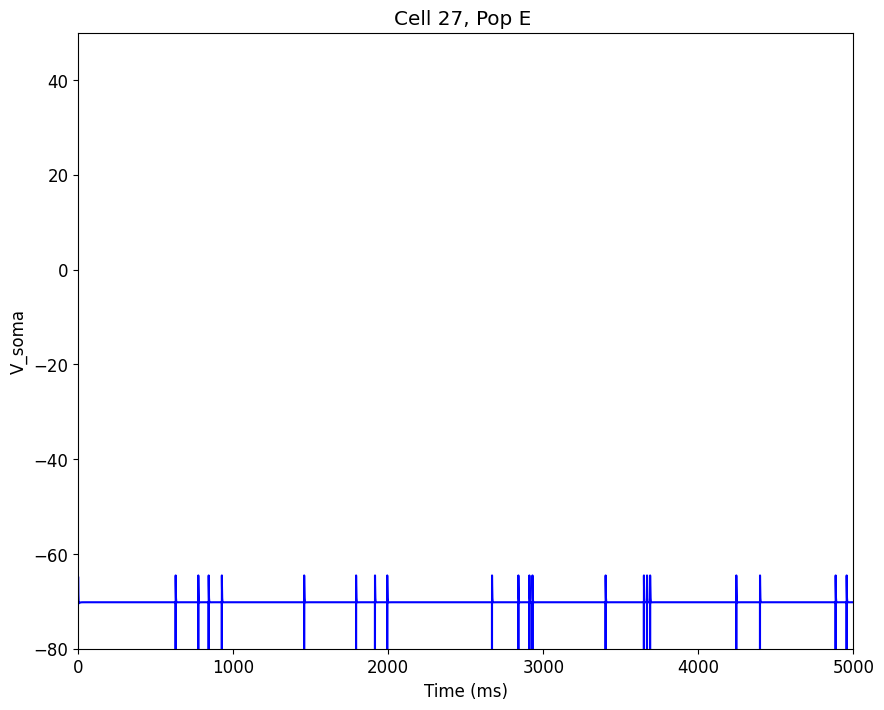

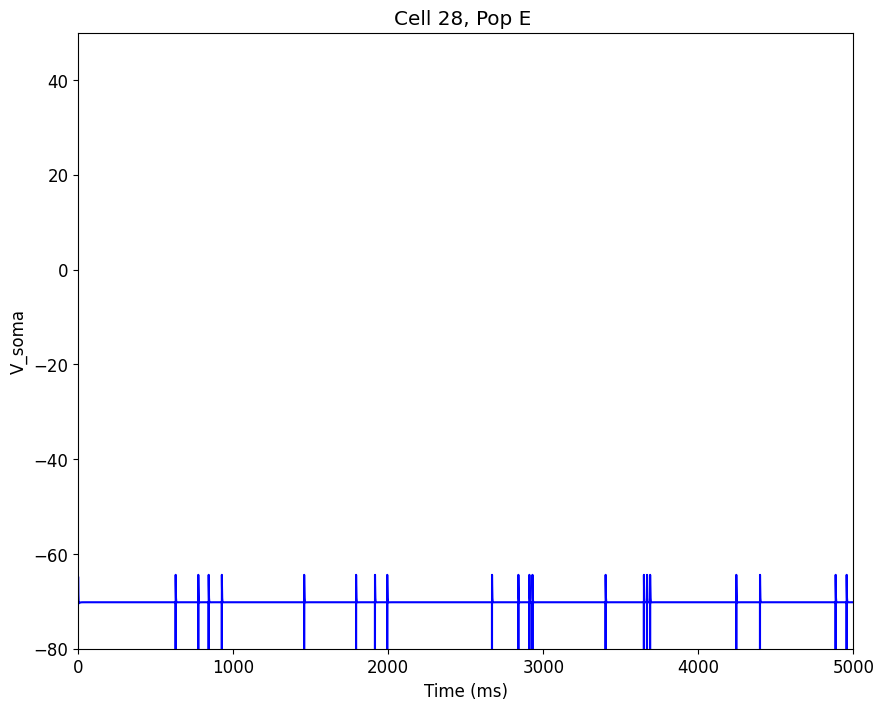

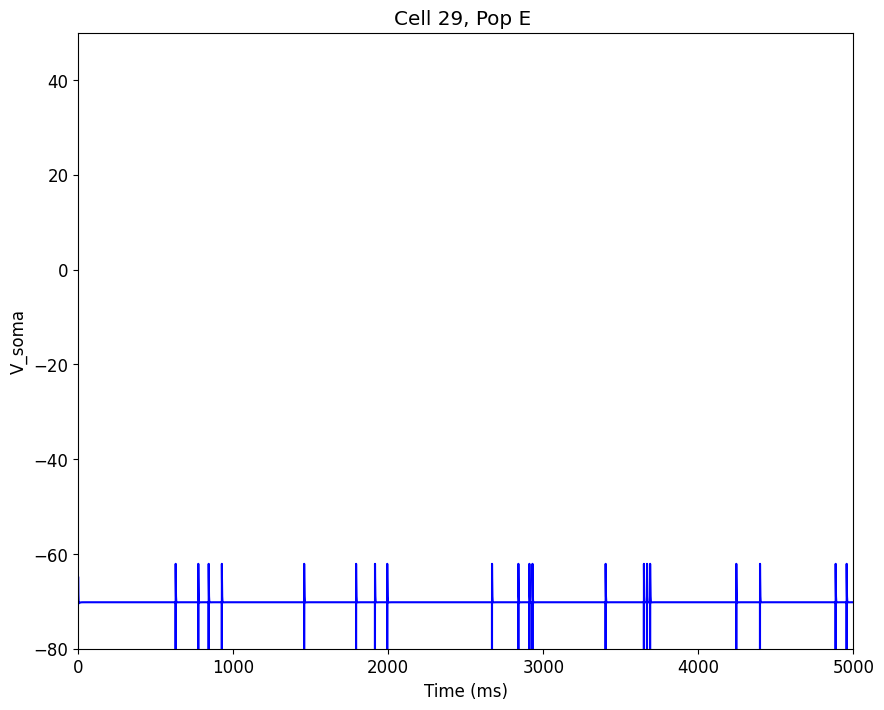

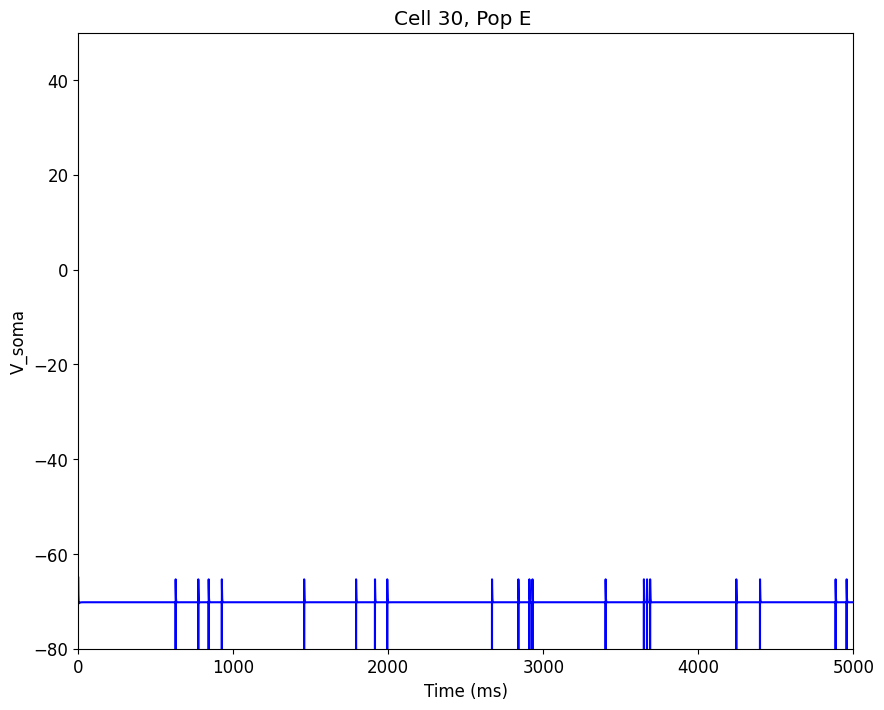

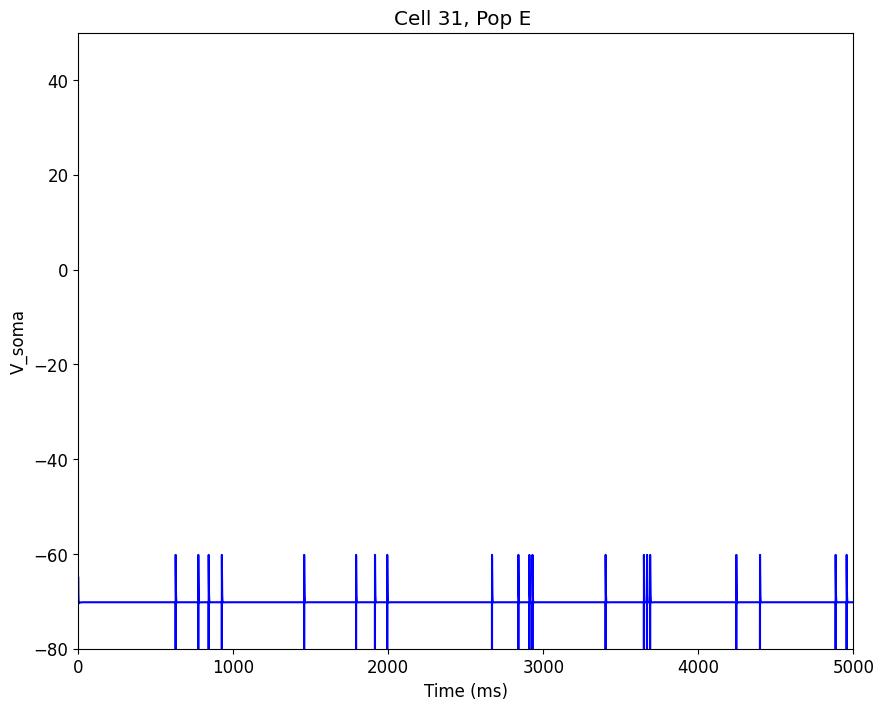

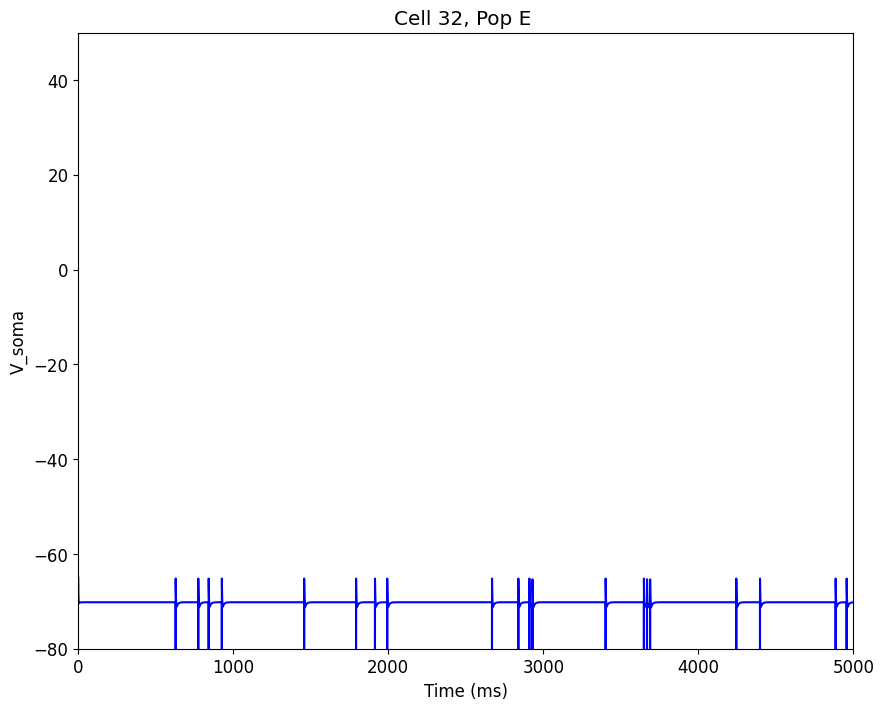

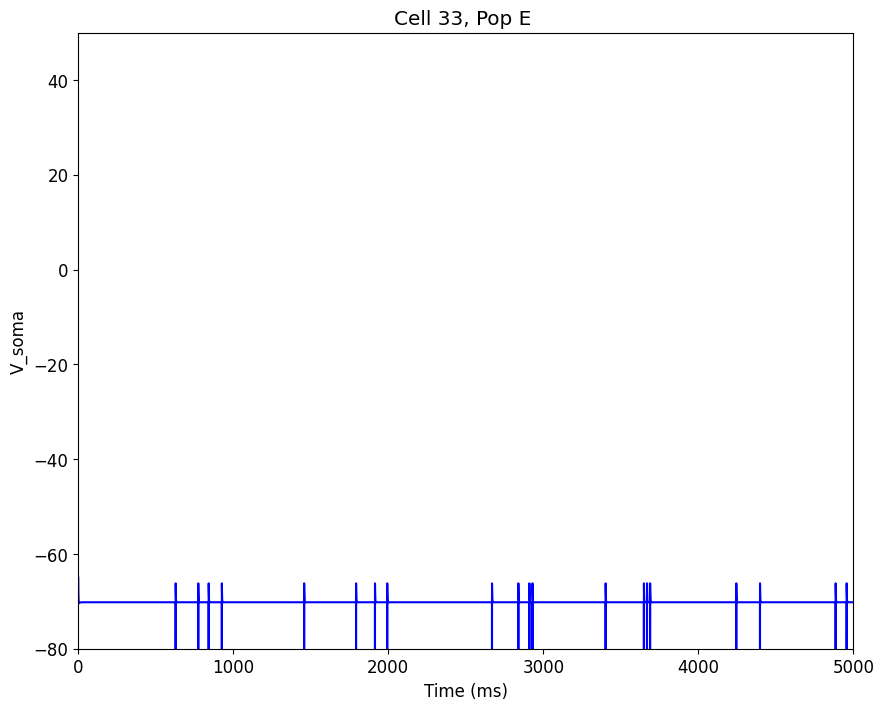

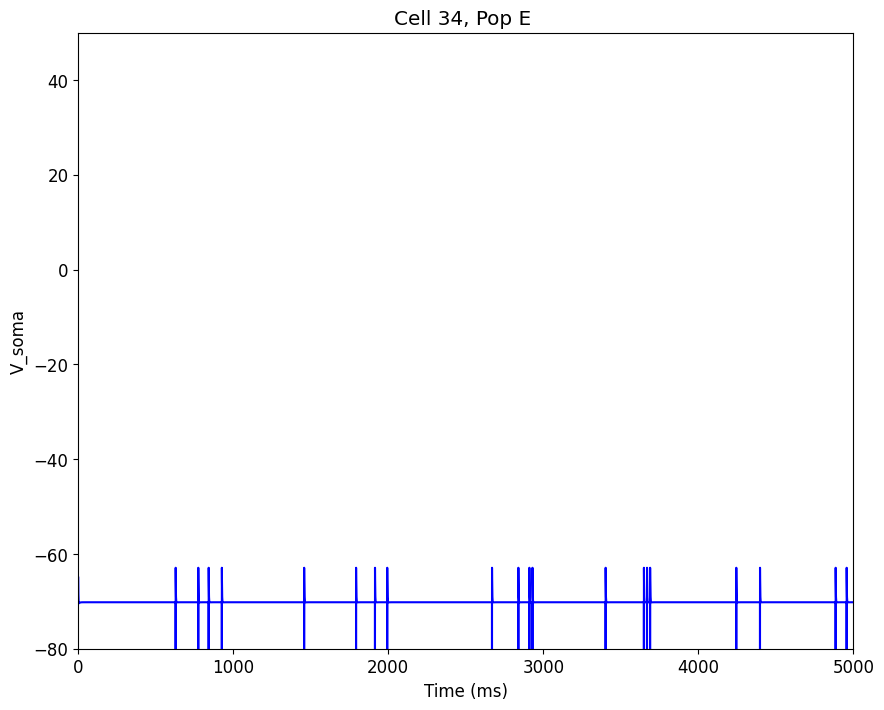

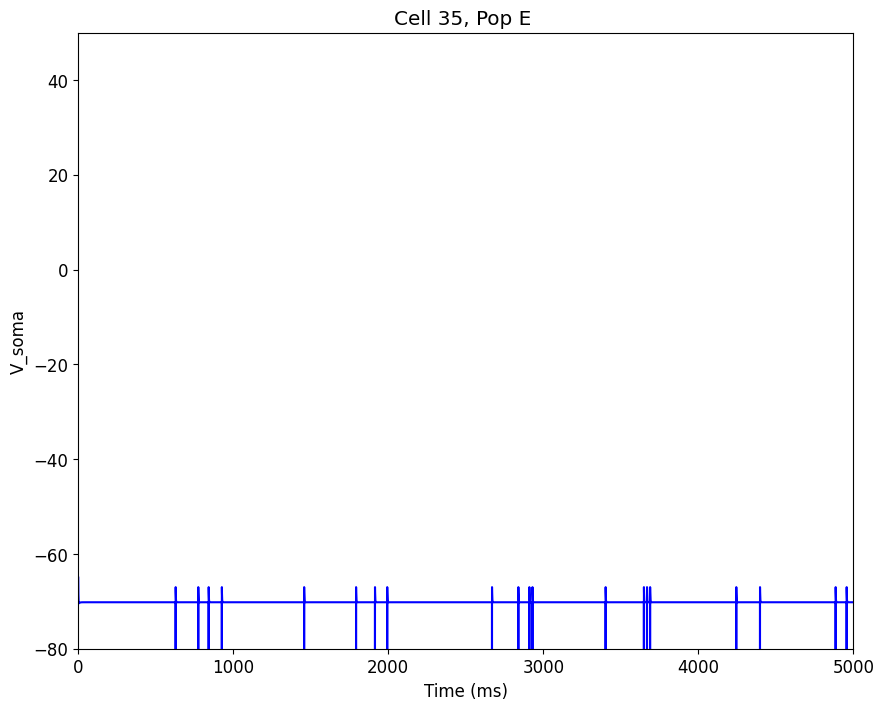

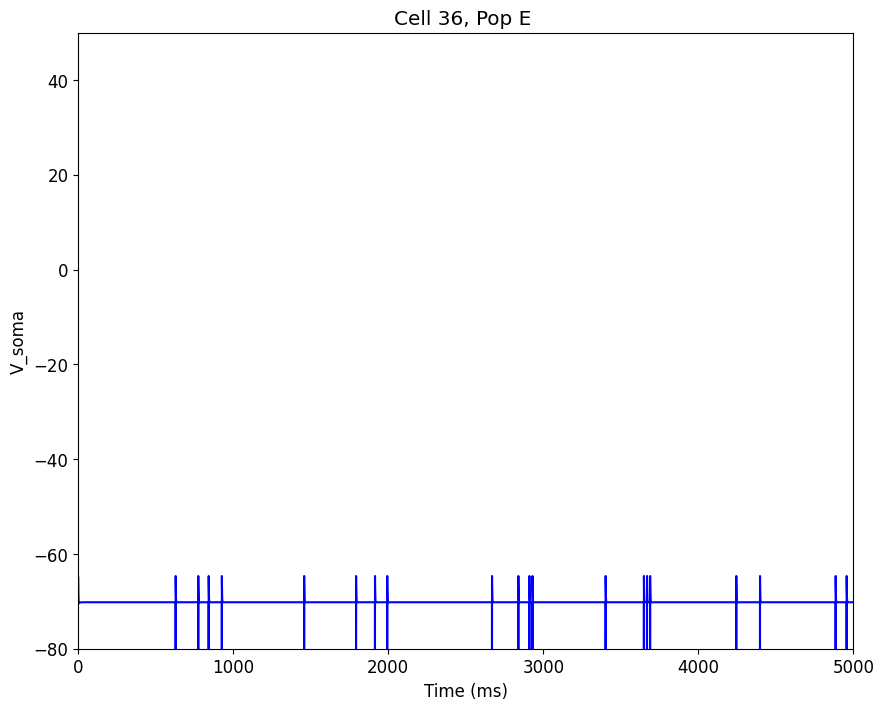

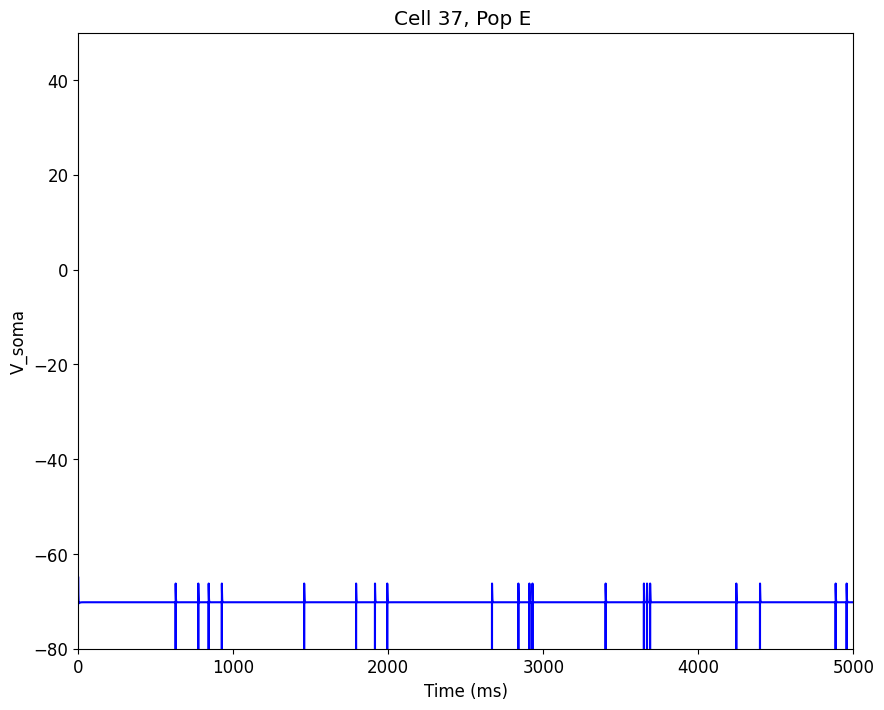

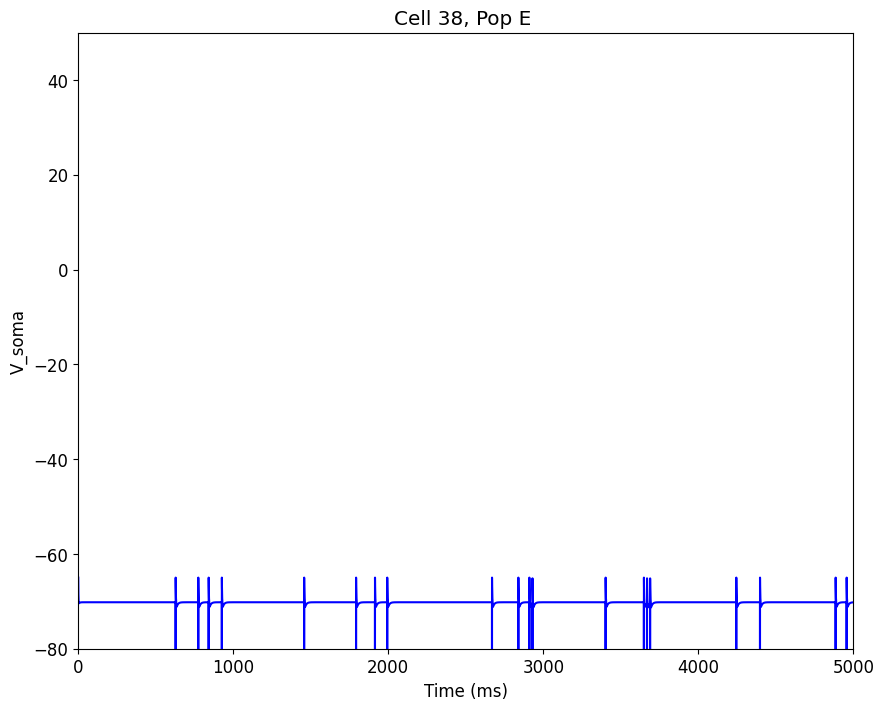

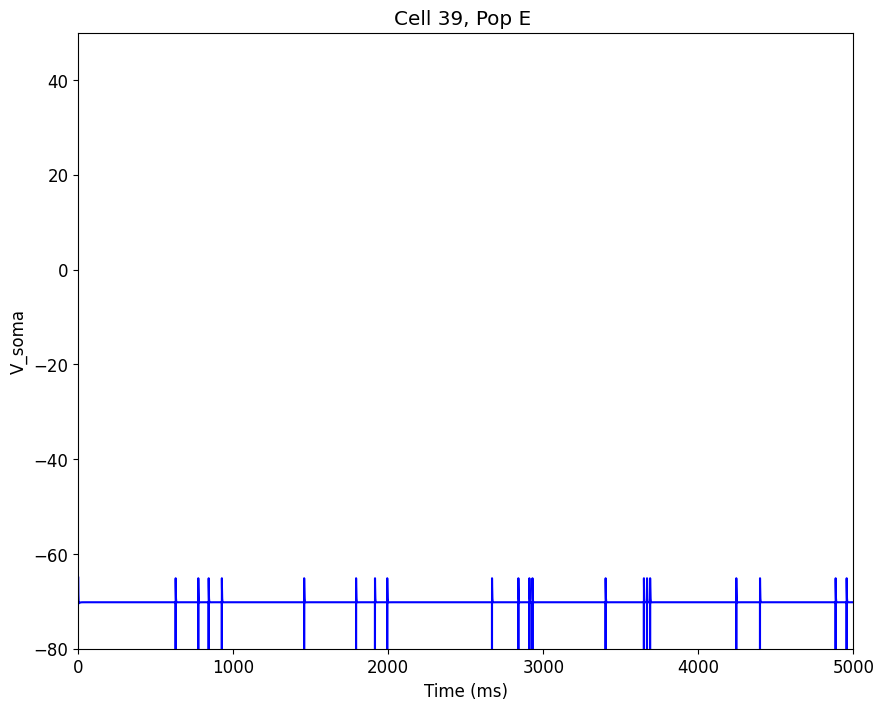

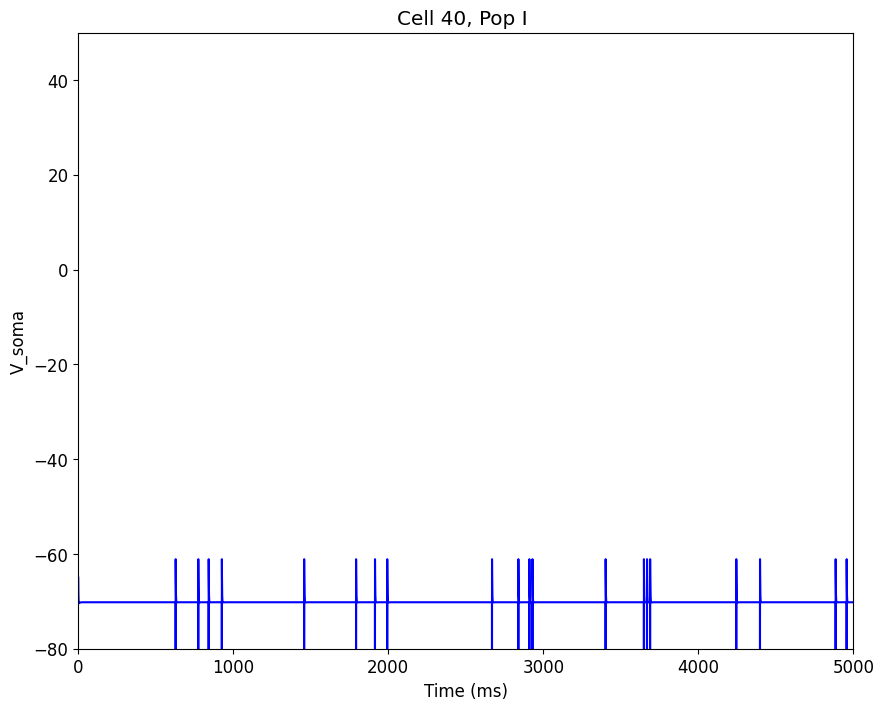

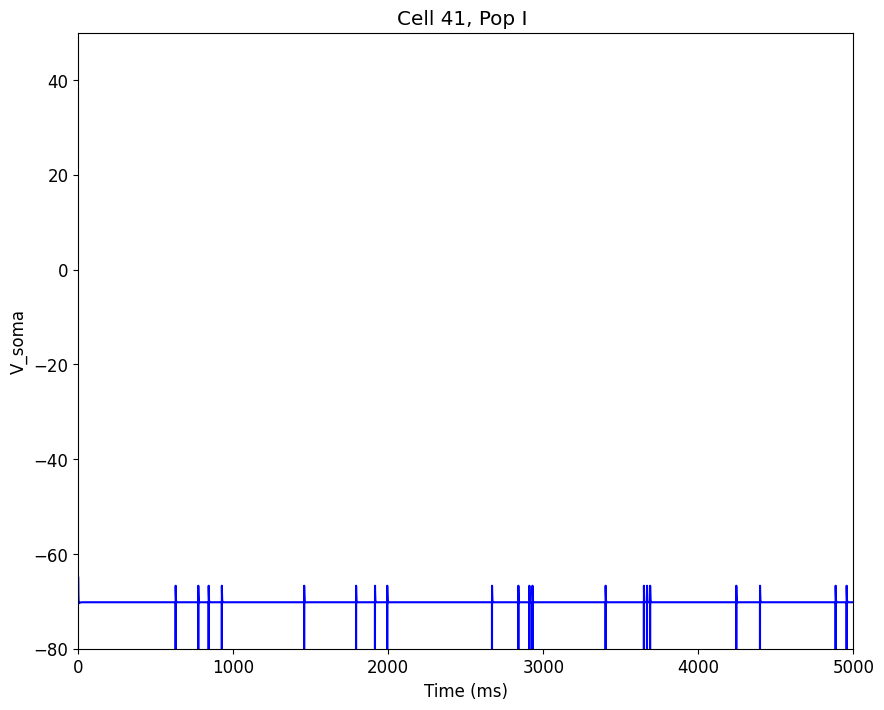

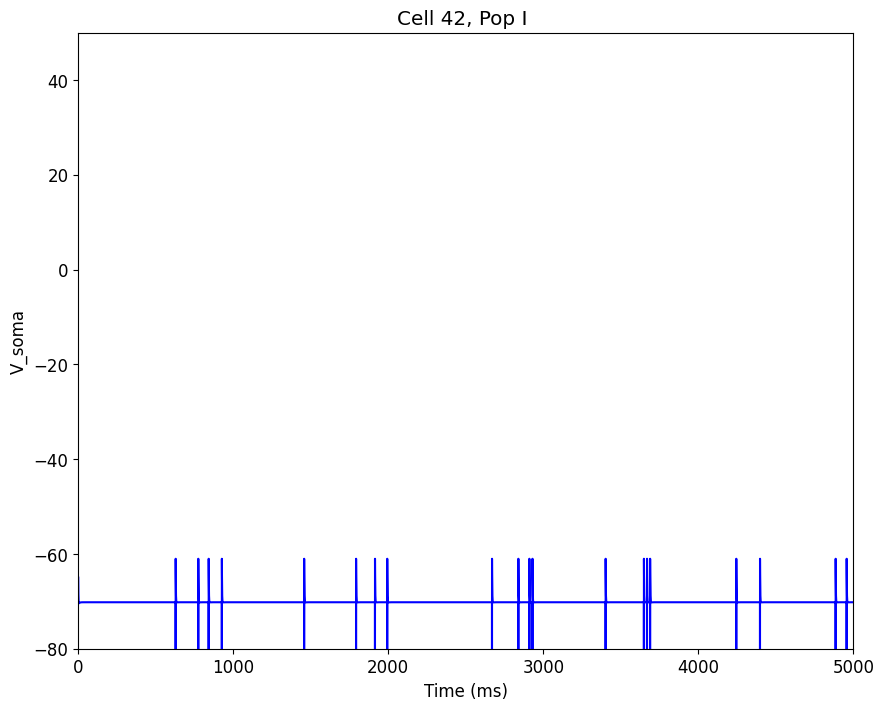

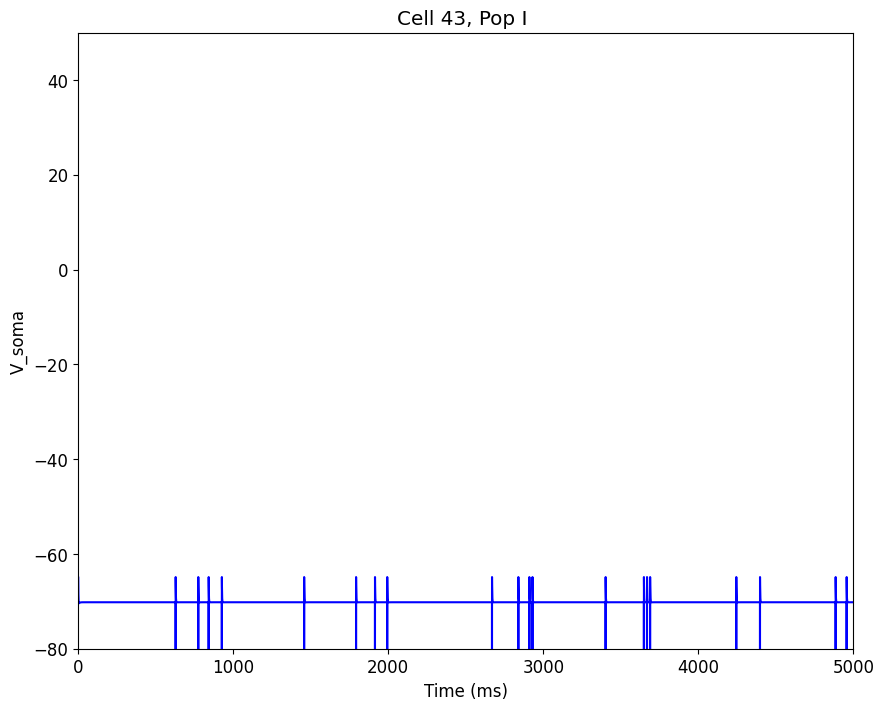

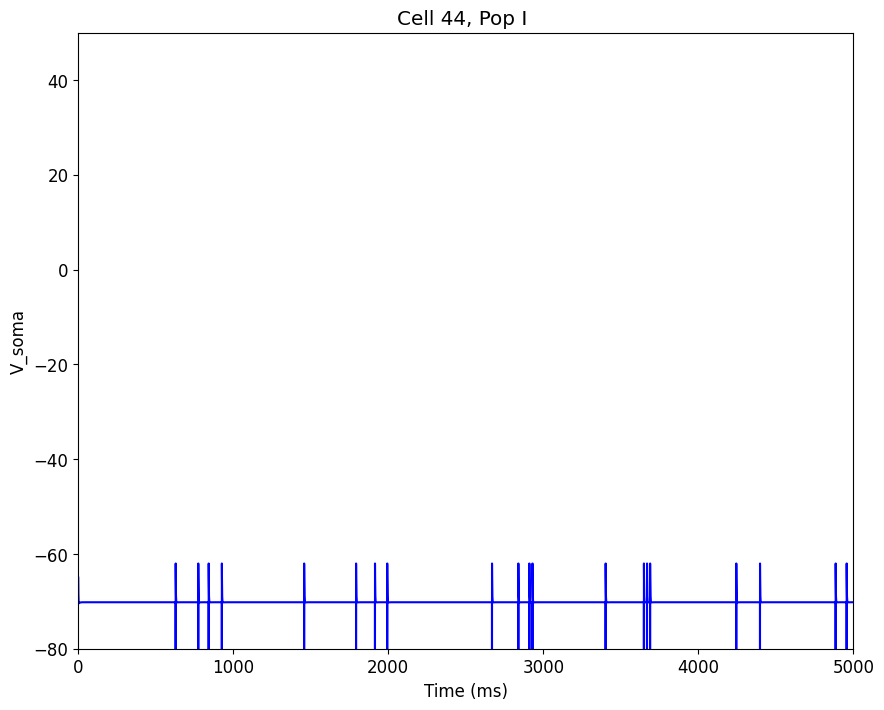

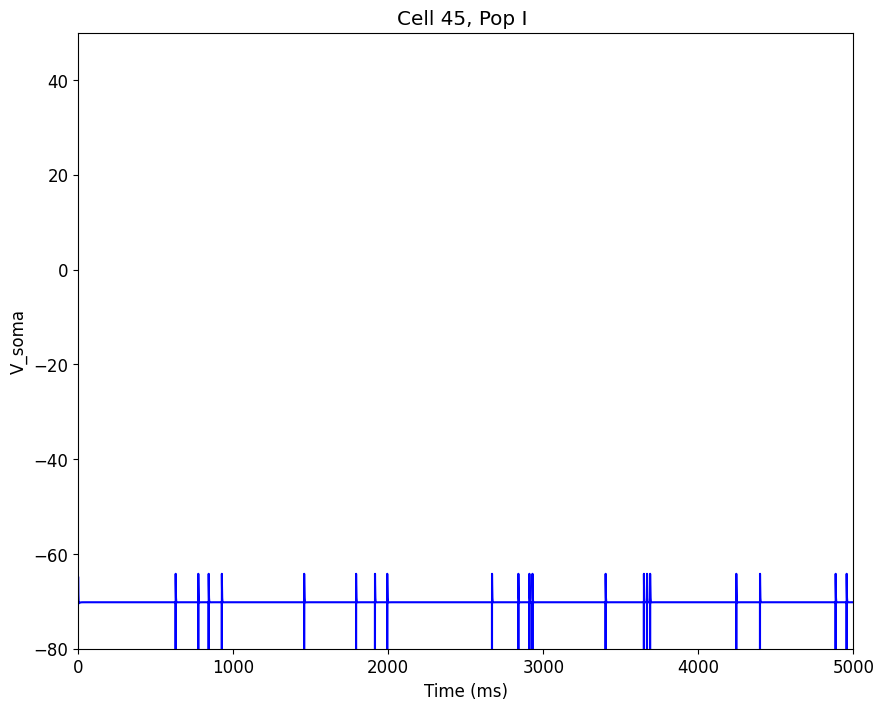

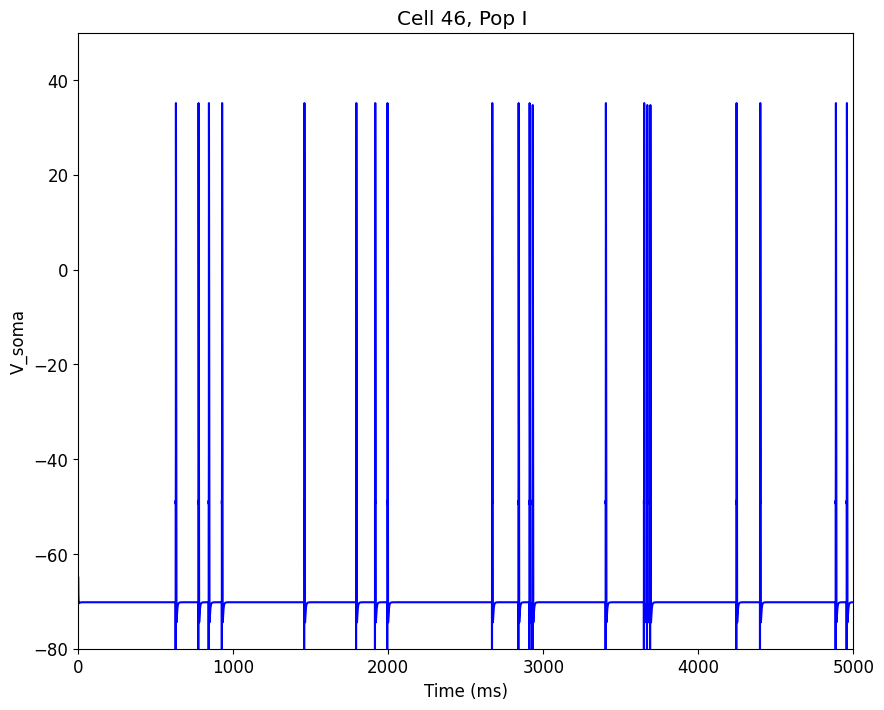

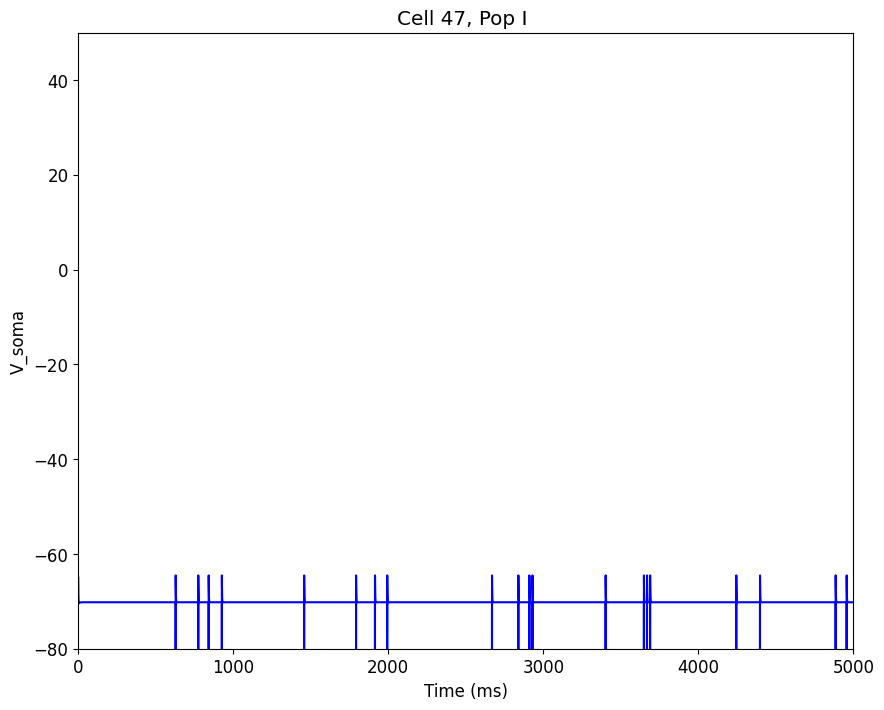

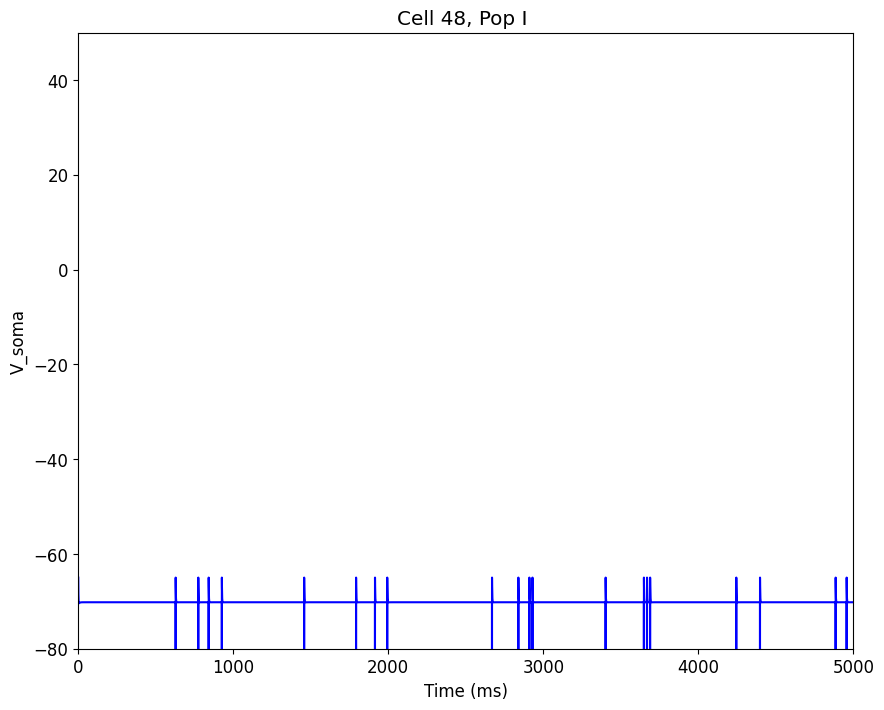

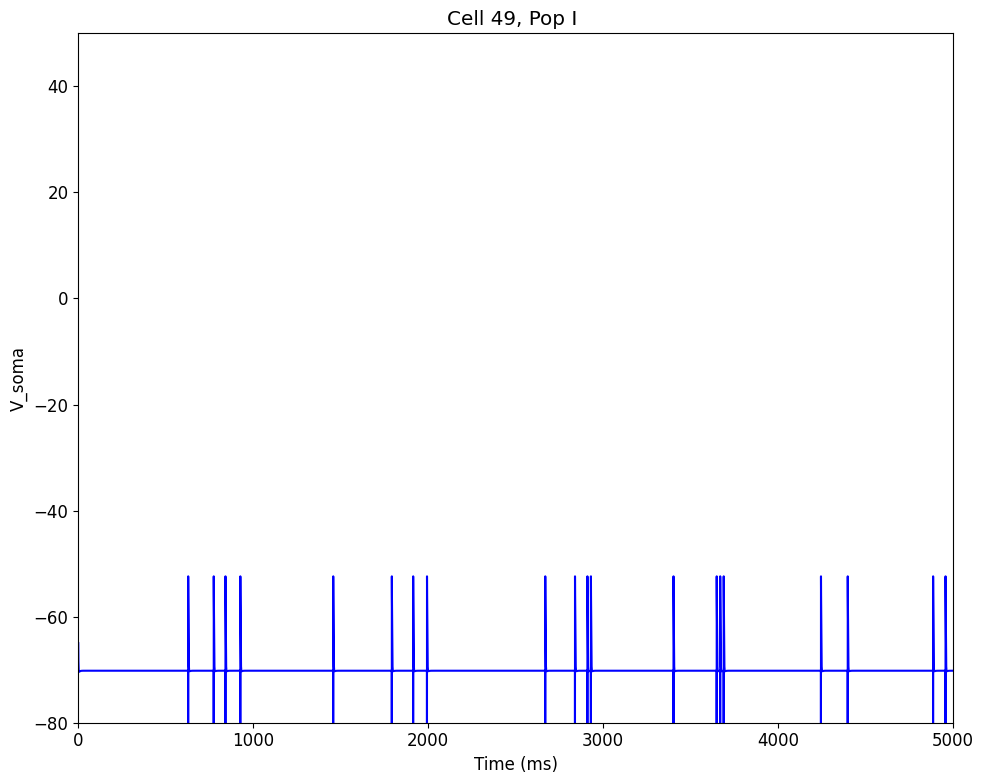

  Done; plotting time = 19.26 s


In [ ]:
sim.analyze() # Plotting the results

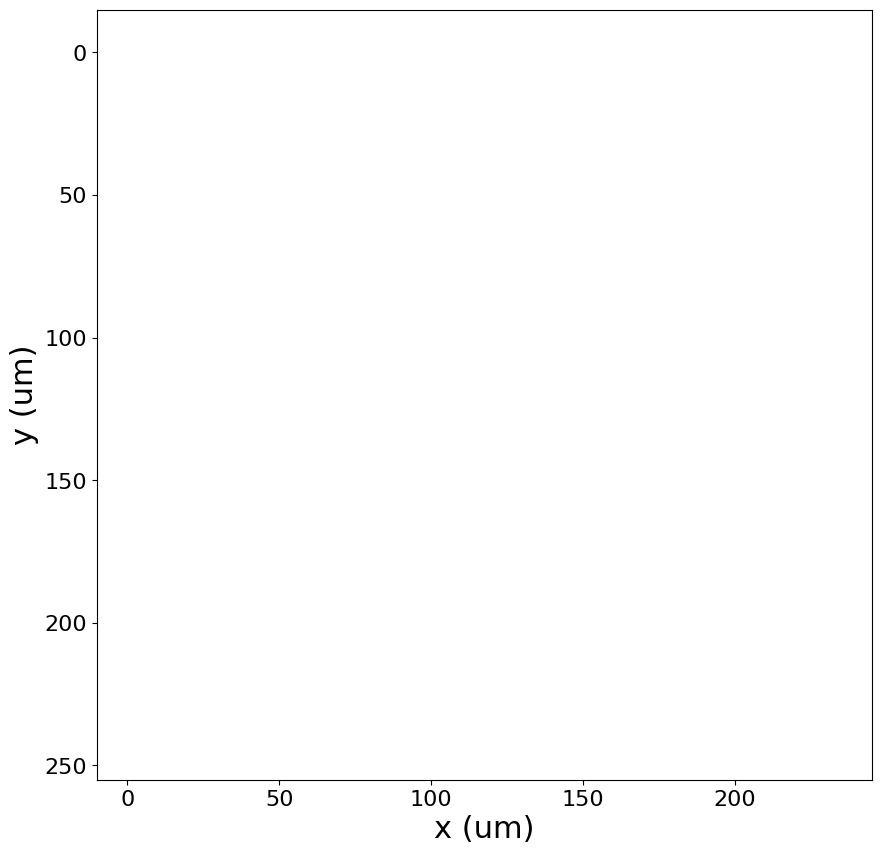

In [ ]:
fontsiz = 22
figSize = (10,10)
fig = plt.figure(figsize=figSize)  # Open a new figure
plt.ylabel('y (um)', fontsize=fontsiz)
plt.xlabel('x (um)', fontsize=fontsiz)
plt.xlim(-10,245)
plt.ylim(255,-15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('2Dnet_portrait.png', facecolor = 'white' , dpi=300)
plt.show()

Plotting 2D representation of network cell locations and connections...


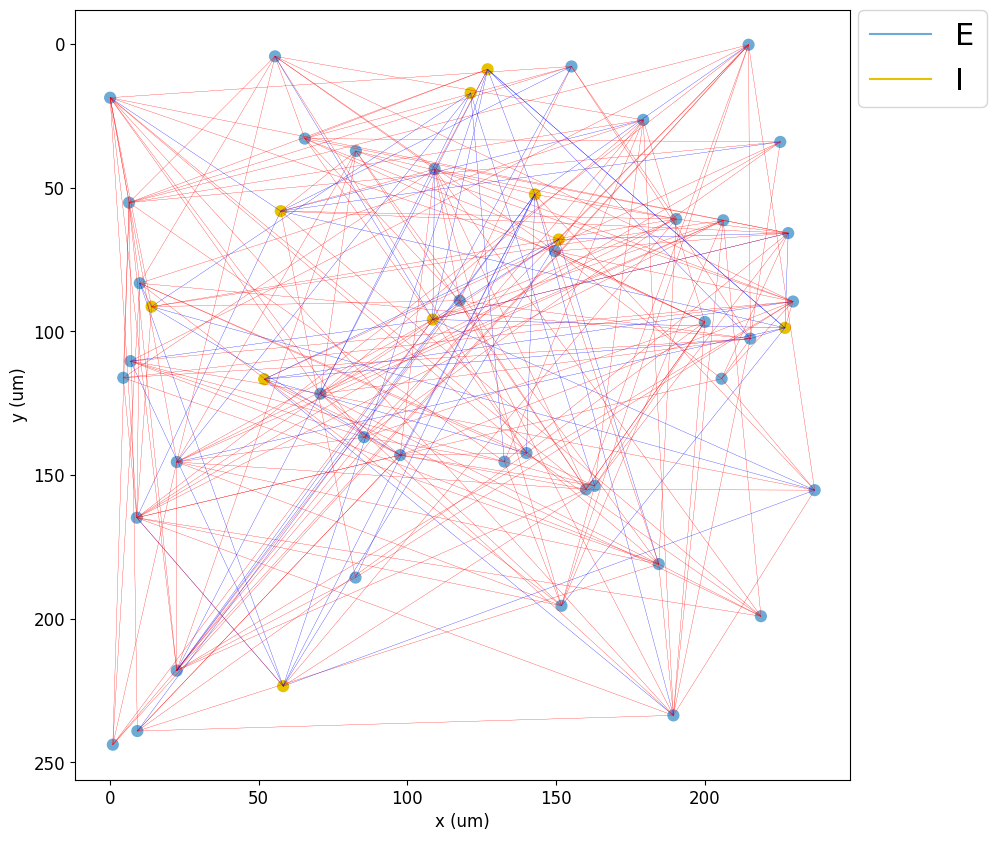

In [ ]:
sim.analysis.plot2Dnet(view='xy', showConns=True,
                               popColors=None, tagsFile=None, figSize=(10, 10), fontSize=22, saveData=None,
                               saveFig=True, showFig=True, lineWidth=0.2);

Preparing spike data...
Plotting raster...


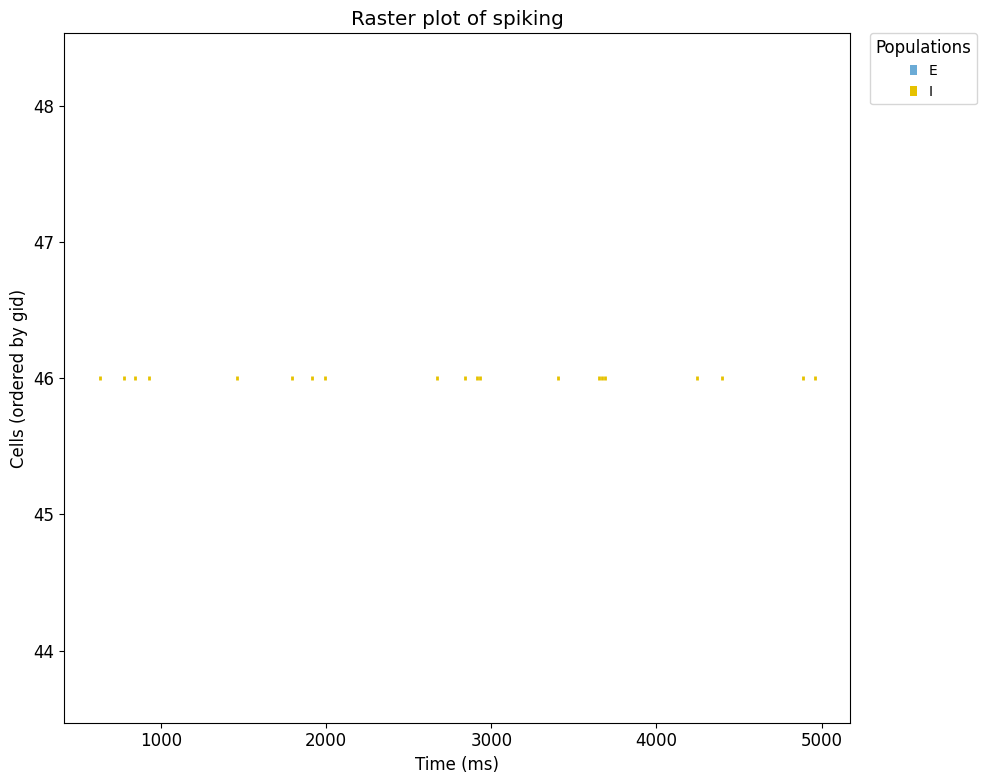

In [ ]:
sim.analysis.plotRaster()

Plotting 2D representation of network cell locations and connections...


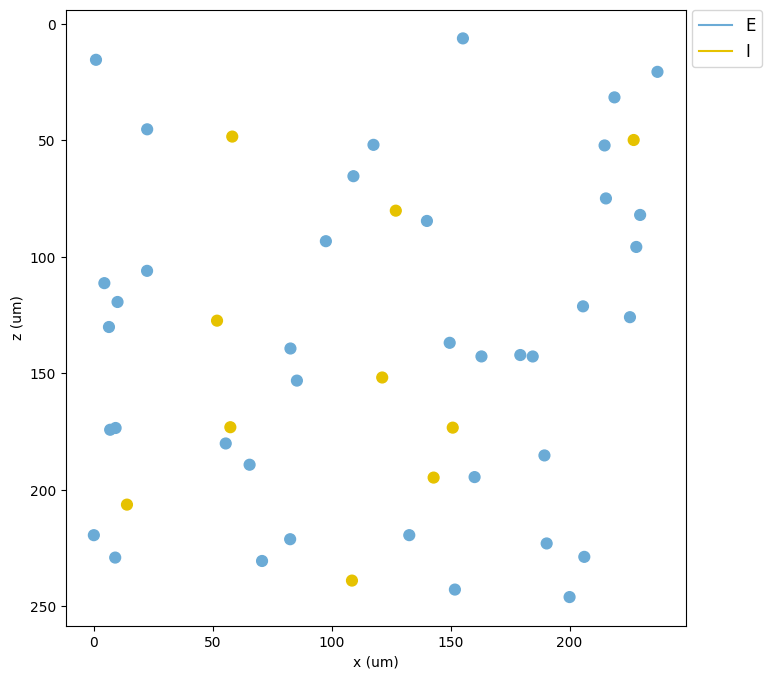

In [ ]:
sim.analysis.plot2Dnet(view='xz', showConns=False,
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None,
                               saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


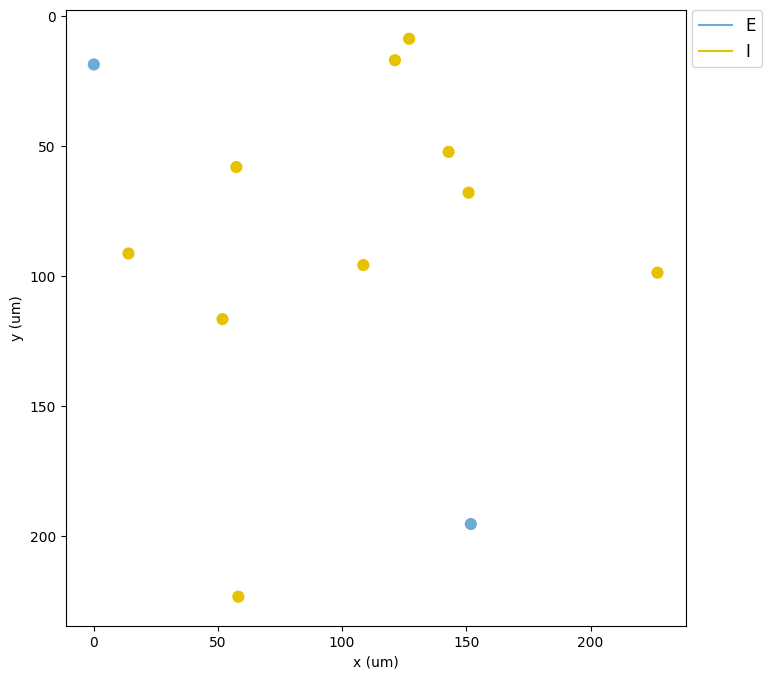

In [ ]:
sim.analysis.plot2Dnet(include=[10,27,40,41,42,43,44,45,46,47,48,49], view='xy', showConns=False,
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None,
                               saveFig=None, showFig=True, lineWidth=0.1,);

Plotting 2D representation of network cell locations and connections...


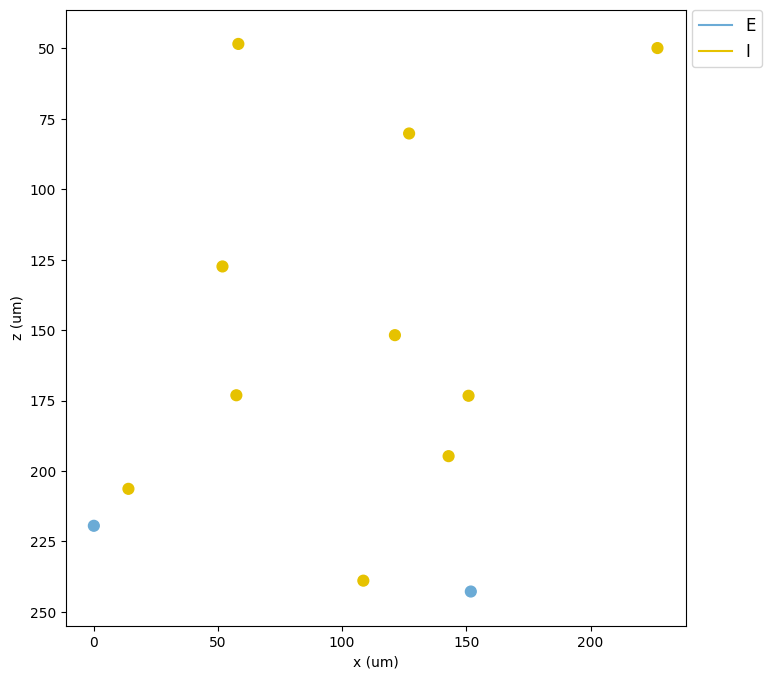

In [ ]:
sim.analysis.plot2Dnet(include=[10,27,40,41,42,43,44,45,46,47,48,49], view='xz', showConns=False,
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None,
                               saveFig=None, showFig=True, lineWidth=0.1,);

In [ ]:
sim.analysis.plotShape(includePre=[27,40,41,42,43,44,45,46,47,48,49], includePost=[27,40,41,42,43,44,45,46,47,48,49],showSyns=False, showElectrodes=True, synStyle='.', synSize=3, dist=0.6, elev=90, azim=-90, cvar=None, cvals=None, iv=False, ivprops=None, includeAxon=True, bkgColor=None, axis='auto', axisLabels=False, figSize=(10, 8), fontSize=12, saveData=None, dpi=300, saveFig=None, showFig=True)

Plotting 3D cell shape ...
  There was an exception in plotShape(): 
    'str' object has no attribute 'figure' 
    (<class 'AttributeError'>, AttributeError("'str' object has no attribute 'figure'"), <traceback object at 0x7fb457ccdb40>)


-1

In [ ]:
sim.simData['V_soma'].keys()

dict_keys(['cell_0', 'cell_1', 'cell_2', 'cell_3', 'cell_4', 'cell_5', 'cell_6', 'cell_7', 'cell_8', 'cell_9', 'cell_10', 'cell_11', 'cell_12', 'cell_13', 'cell_14', 'cell_15', 'cell_16', 'cell_17', 'cell_18', 'cell_19', 'cell_20', 'cell_21', 'cell_22', 'cell_23', 'cell_24', 'cell_25', 'cell_26', 'cell_27', 'cell_28', 'cell_29', 'cell_30', 'cell_31', 'cell_32', 'cell_33', 'cell_34', 'cell_35', 'cell_36', 'cell_37', 'cell_38', 'cell_39', 'cell_40', 'cell_41', 'cell_42', 'cell_43', 'cell_44', 'cell_45', 'cell_46', 'cell_47', 'cell_48', 'cell_49'])

In [ ]:
Traces = {}

for stimtype in ['periodic', 'burst', 'NPSLH', 'NPS']:
  Traces[stimtype] = []
  for c in list(sim.simData['V_soma'].keys())[0:2]:
    Traces[stimtype].append(np.array(sim.simData['V_soma'][c]))

In [ ]:
Traces['periodic'] = []
for c in list(sim.simData['V_soma'].keys())[0:2]:
  Traces['periodic'].append(np.array(sim.simData['V_soma'][c]))

In [ ]:
netpyneTraces = []
for c in list(sim.simData['V_soma'].keys())[0:50]:
  netpyneTraces.append(np.array(sim.simData['V_soma'][c]))

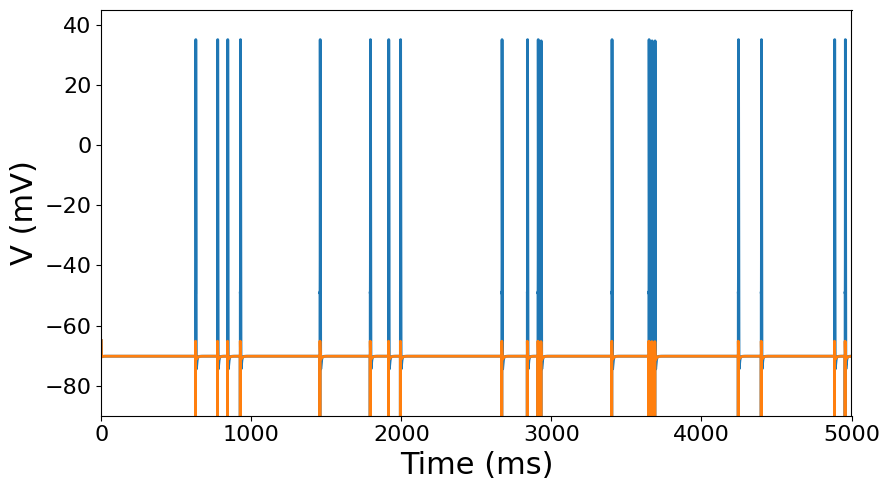

In [ ]:
# plot both traces overlayed
fontsiz=22
timeRange = [0, 5000]
recordStep = 0.01
# ~ ylim = [-100, 40]
figSize = (9,5)
fig = plt.figure(figsize=figSize)  # Open a new figure

# fig.suptitle('subtitle', fontsize=15, fontweight='bold')

t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep)

for c in range(1):
    netpyneTrace = netpyneTraces[c]
    plt.subplot(1, 1, 1)
    plt.ylabel('V (mV)', fontsize=fontsiz)
    netpyneTrace = netpyneTraces[46]
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, label='cell '+str(46))
    netpyneTrace = netpyneTraces[32]
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, label='cell '+str(32))
    plt.xlim(0, 5000)
    plt.ylim(-90,45)
    plt.grid(False)
    # plt.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.xlabel('Time (ms)', fontsize=fontsiz)
plt.ion()
plt.tight_layout()

plt.savefig('figure2_extra_Periodic_Cathodic.png', facecolor = 'white' , dpi=300)
plt.show()

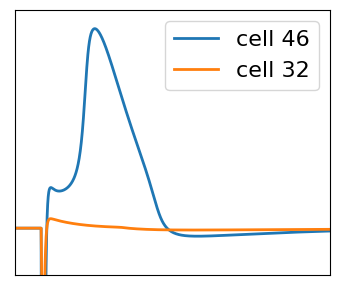

In [ ]:
# plot both traces overlayed
fontsiz=22
timeRange = [0, 5000]
recordStep = 0.01
# ~ ylim = [-100, 40]
figSize = (3.5,3)
fig = plt.figure(figsize=figSize)  # Open a new figure

# fig.suptitle('subtitle', fontsize=15, fontweight='bold')

t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep)

for c in range(1):
    netpyneTrace = netpyneTraces[c]
    plt.subplot(1, 1, 1)
    # plt.ylabel('V (mV)', fontsize=fontsiz)
    netpyneTrace = netpyneTraces[46]
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, label='cell '+str(46))
    netpyneTrace = netpyneTraces[32]
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, label='cell '+str(32))
    plt.xlim(773, 785)
    plt.ylim(-95,45)
    plt.grid(False)
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=16)
    plt.xticks([], fontsize=15)
    plt.yticks([], fontsize=14)
# plt.xlabel('Time (ms)', fontsize=fontsiz)
plt.ion()
plt.tight_layout()

plt.savefig('figure2_extra_Periodic_Cathodic_zoom.png', facecolor = 'white' , dpi=300)
plt.show()

In [ ]:
npslh[0]

347.63335732446154